## Scrape data for average speed and overall distance from procyclingstats.com

In [38]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

# URL with historical Tour stats
url = "https://www.procyclingstats.com/race/tour-de-france/results/fastest-editions"
resp = requests.get(url)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table rows
table = soup.select_one("table.basic")
rows = table.select("tbody tr")

data = []
for row in rows:
    cols = [c.text.strip() for c in row.select("td")]
    # Expect columns: Edition, Year, Distance, Avg. speed, Longest, Shortest, etc.
    try:
        year = int(cols[1])
        distance = float(cols[2])
        avg_speed = float(cols[3])
        data.append({
            'Year': year,
            'Total_Distance_km': distance,
            'Average_Speed_kmh': avg_speed
        })
    except:
        continue

df_speeds = pd.DataFrame(data)
df_speeds = df_speeds.sort_values('Year').reset_index(drop=True)
print(df_speeds.head(), df_speeds.tail())

# Export to CSV
df_speeds.to_csv("tdf_speeds_distances_historical.csv", index=False)


   Year  Total_Distance_km  Average_Speed_kmh
0  1903             2428.0            25.6786
1  1904             2429.0            25.2650
2  1905             3021.0            27.4805
3  1906             4543.0            26.2856
4  1907             4488.0            28.2450      Year  Total_Distance_km  Average_Speed_kmh
108  2022             3350.0            42.1017
109  2023             3405.0            41.4134
110  2024             3498.0            41.8075
111  2025             3320.0             0.0000
112  2026              198.0             0.0000


In [39]:
df_speeds.tail()

,Year,Total_Distance_km,Average_Speed_kmh
108,2022,3350.0,42.1017
109,2023,3405.0,41.4134
110,2024,3498.0,41.8075
111,2025,3320.0,0.0000
112,2026,198.0,0.0000


In [40]:
df_speeds = df_speeds[~df_speeds['Year'].isin([2025, 2026])].reset_index(drop=True)
df_speeds.tail()

,Year,Total_Distance_km,Average_Speed_kmh
106,2020,3482.0,39.8678
107,2021,3414.0,41.1581
108,2022,3350.0,42.1017
109,2023,3405.0,41.4134
110,2024,3498.0,41.8075


In [41]:
df_speeds.dtypes

Year                   int64
Total_Distance_km    float64
Average_Speed_kmh    float64
dtype: object

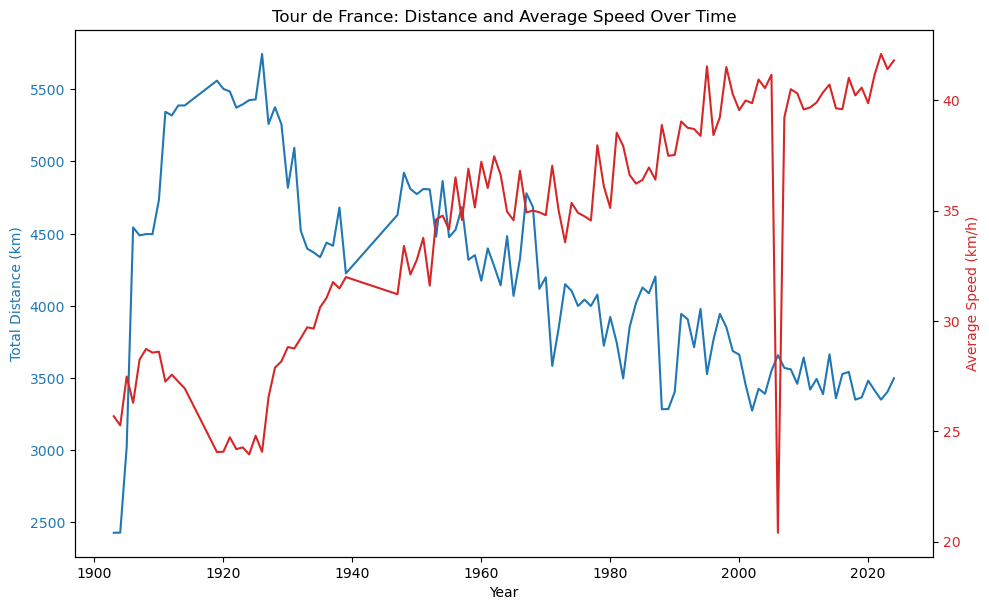

In [42]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Distance (km)', color=color)
ax1.plot(df_speeds['Year'], df_speeds['Total_Distance_km'], color=color, label='Total Distance (km)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Speed (km/h)', color=color)
ax2.plot(df_speeds['Year'], df_speeds['Average_Speed_kmh'], color=color, label='Average Speed (km/h)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Tour de France: Distance and Average Speed Over Time')
plt.show()

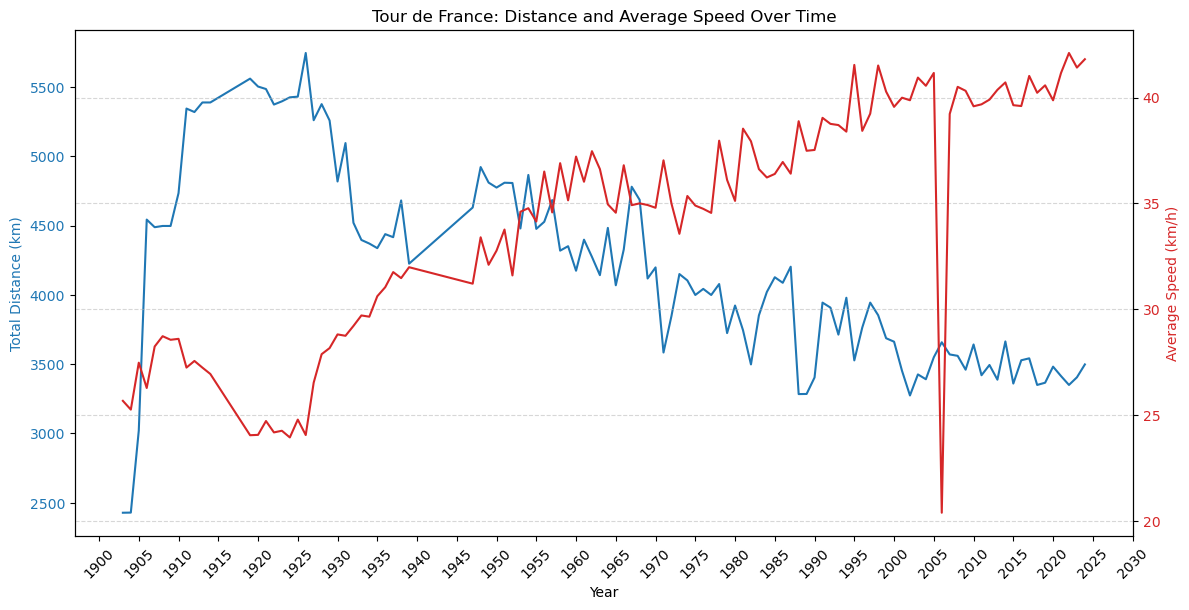

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12, 6))  # slightly wider for clarity

# Plot total distance
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Distance (km)', color=color)
ax1.plot(df_speeds['Year'], df_speeds['Total_Distance_km'], color=color, label='Total Distance (km)')
ax1.tick_params(axis='y', labelcolor=color)

# Show x-ticks every 5 years
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45)

# Plot average speed
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Speed (km/h)', color=color)
ax2.plot(df_speeds['Year'], df_speeds['Average_Speed_kmh'], color=color, label='Average Speed (km/h)')
ax2.tick_params(axis='y', labelcolor=color)

# Final layout
fig.tight_layout()
plt.title('Tour de France: Distance and Average Speed Over Time')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


c:\Users\raclo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\raclo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


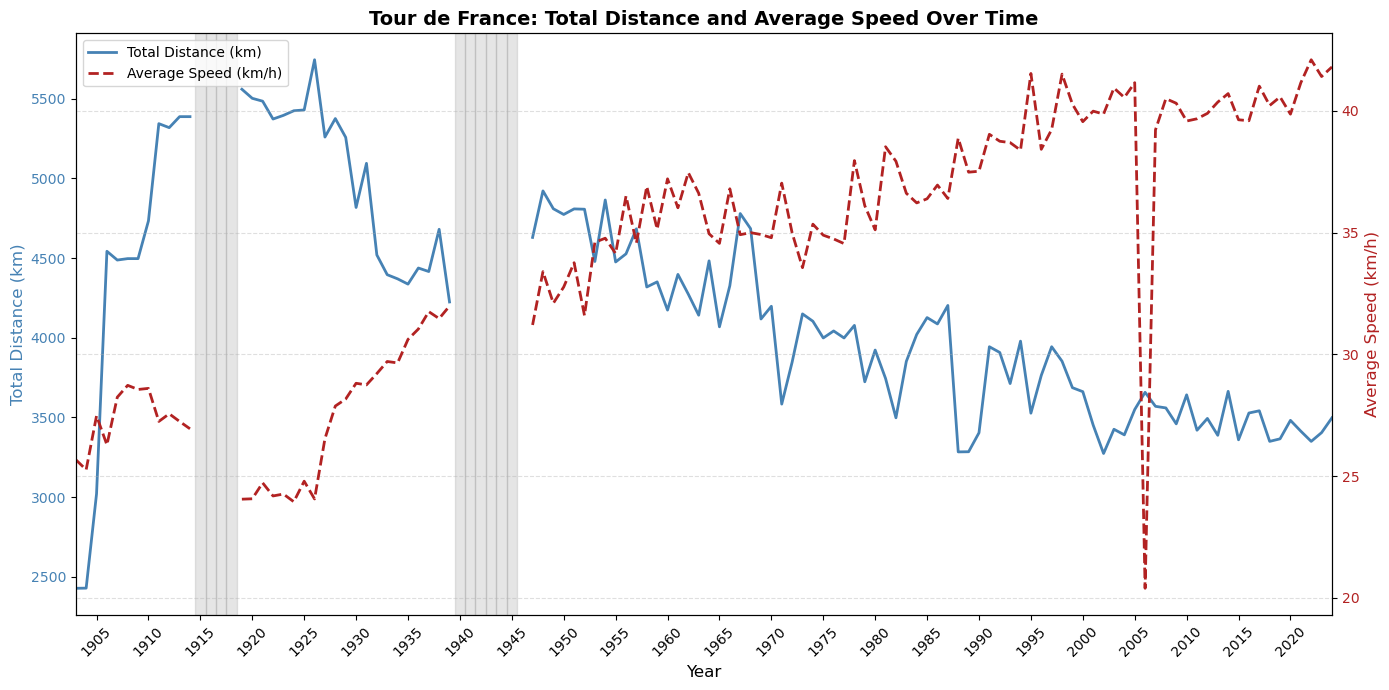

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

missing_years = [1915, 1916, 1917, 1918, 1940, 1941, 1942, 1943, 1944, 1945]

def split_by_missing_years(df, missing_years):
    # Create a mask to exclude missing years
    mask = ~df['Year'].isin(missing_years)
    # Filter dataframe
    df_filtered = df[mask].reset_index(drop=True)

    # Find breaks in consecutive years to split segments
    years = df_filtered['Year'].values
    splits = np.where(np.diff(years) > 1)[0] + 1
    segments = np.split(df_filtered, splits)
    return segments

# Split dataset into continuous segments (excluding missing years)
distance_segments = split_by_missing_years(df_speeds[['Year', 'Total_Distance_km']], missing_years)
speed_segments = split_by_missing_years(df_speeds[['Year', 'Average_Speed_kmh']], missing_years)

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = 'steelblue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Distance (km)', color=color1, fontsize=12)

# Plot each continuous segment separately for distance
for segment in distance_segments:
    ax1.plot(segment['Year'], segment['Total_Distance_km'], color=color1, linewidth=2, label='_nolegend_')

ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45)
ax1.set_xlim(1903, 2024)

# Plot missing years as grey bands
for year in missing_years:
    ax1.axvspan(year - 0.5, year + 0.5, color='grey', alpha=0.2)

color2 = 'firebrick'
ax2 = ax1.twinx()
ax2.set_ylabel('Average Speed (km/h)', color=color2, fontsize=12)

# Plot each continuous segment separately for average speed
for segment in speed_segments:
    ax2.plot(segment['Year'], segment['Average_Speed_kmh'], color=color2, linewidth=2, linestyle='--', label='_nolegend_')

ax2.tick_params(axis='y', labelcolor=color2)

# Create manual legend
line1 = plt.Line2D([], [], color=color1, linewidth=2, label='Total Distance (km)')
line2 = plt.Line2D([], [], color=color2, linewidth=2, linestyle='--', label='Average Speed (km/h)')
plt.legend(handles=[line1, line2], loc='upper left')

plt.title('Tour de France: Total Distance and Average Speed Over Time', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
fig.tight_layout()
plt.show()


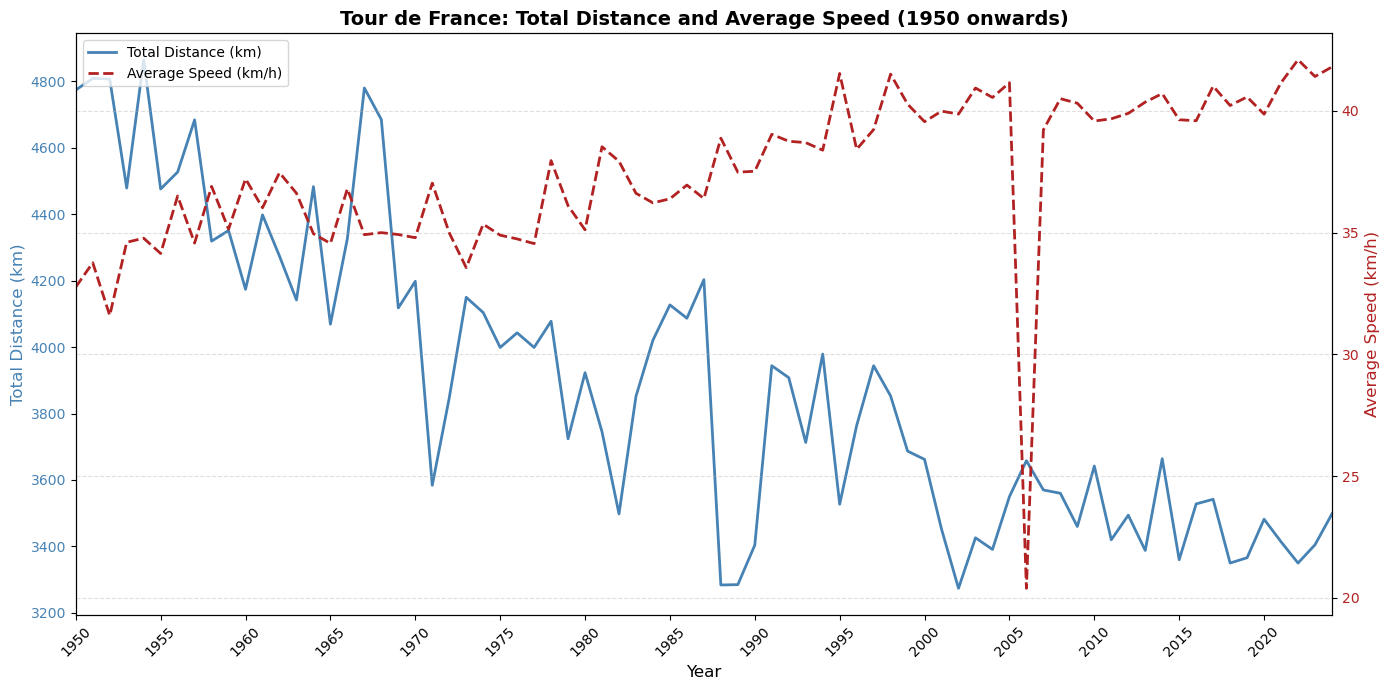

In [45]:
# Filter the dataframe for years >= 1950
df_1950_onwards = df_speeds[df_speeds['Year'] >= 1950].reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = 'steelblue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Distance (km)', color=color1, fontsize=12)
ax1.plot(df_1950_onwards['Year'], df_1950_onwards['Total_Distance_km'], color=color1, linewidth=2, label='Total Distance (km)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45)
ax1.set_xlim(1950, df_1950_onwards['Year'].max())

color2 = 'firebrick'
ax2 = ax1.twinx()
ax2.set_ylabel('Average Speed (km/h)', color=color2, fontsize=12)
ax2.plot(df_1950_onwards['Year'], df_1950_onwards['Average_Speed_kmh'], color=color2, linewidth=2, linestyle='--', label='Average Speed (km/h)')
ax2.tick_params(axis='y', labelcolor=color2)

# Create manual legend
line1 = plt.Line2D([], [], color=color1, linewidth=2, label='Total Distance (km)')
line2 = plt.Line2D([], [], color=color2, linewidth=2, linestyle='--', label='Average Speed (km/h)')
plt.legend(handles=[line1, line2], loc='upper left')

plt.title('Tour de France: Total Distance and Average Speed (1950 onwards)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
fig.tight_layout()
plt.show()

In [46]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://www.procyclingstats.com/race/tour-de-france/2024/results/average-speed-per-stage"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

text = soup.get_text()

# Regex to find the average speed value between the phrases
match = re.search(r"The average speed over all stages is ([\d\.]+) km/hour", text)

if match:
    avg_speed = float(match.group(1))
    print(f"Average Speed: {avg_speed} km/h")
else:
    print("Average speed not found")


Average Speed: 41.8075 km/h


In [47]:
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd

years = list(range(2014, 2024))  # last 10 years (adjust as needed)
data = []

for year in years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/results/average-speed-per-stage"
    print(f"Scraping {year}...")
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        page_text = soup.get_text()
        
        # Extract average speed using regex
        speed_match = re.search(r"The average speed over all stages is ([\d\.]+) km/hour", page_text)
        avg_speed = float(speed_match.group(1)) if speed_match else None
        
        # Extract total distance from the table row with class 'sum'
        total_distance = None
        sum_row = soup.select_one("tr.sum")
        if sum_row:
            # Usually the distance is in a 'td' somewhere inside sum_row, find the first with "km"
            for td in sum_row.find_all("td"):
                if "km" in td.text:
                    dist_text = td.text.strip().replace(" km", "").replace(",", "")
                    try:
                        total_distance = float(dist_text)
                    except ValueError:
                        total_distance = None
                    break
        
        print(f"Year {year}: Avg Speed = {avg_speed}, Total Distance = {total_distance}")
        data.append({'Year': year, 'Average_Speed_kmh': avg_speed, 'Total_Distance_km': total_distance})
        
    except Exception as e:
        print(f"Error scraping year {year}: {e}")
        data.append({'Year': year, 'Average_Speed_kmh': None, 'Total_Distance_km': None})
    
    time.sleep(1.5)  # be polite, don't overload the server

df = pd.DataFrame(data)
print(df)


Scraping 2014...
Year 2014: Avg Speed = 40.7123, Total Distance = None
Scraping 2015...
Year 2015: Avg Speed = 39.6373, Total Distance = None
Scraping 2016...
Year 2016: Avg Speed = 39.5973, Total Distance = None
Scraping 2017...
Year 2017: Avg Speed = 41.0182, Total Distance = None
Scraping 2018...
Year 2018: Avg Speed = 40.224, Total Distance = None
Scraping 2019...
Year 2019: Avg Speed = 40.5752, Total Distance = None
Scraping 2020...
Year 2020: Avg Speed = 39.8678, Total Distance = None
Scraping 2021...
Year 2021: Avg Speed = 41.1581, Total Distance = None
Scraping 2022...
Year 2022: Avg Speed = 42.1017, Total Distance = None
Scraping 2023...
Year 2023: Avg Speed = 41.4134, Total Distance = None
   Year  Average_Speed_kmh Total_Distance_km
0  2014            40.7123              None
1  2015            39.6373              None
2  2016            39.5973              None
3  2017            41.0182              None
4  2018            40.2240              None
5  2019            40

In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

years = list(range(2014, 2024))  # last 10 years
data = []

for year in years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/results/average-speed-per-stage"
    print(f"Scraping {year}...", end=" ")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract average speed from the div with class "text-regular"
        avg_speed = None
        divs = soup.select("div.text-regular")
        for div in divs:
            text = div.get_text(strip=True)
            match = re.search(r"The average speed over all stages is ([\d\.]+)", text)
            if match:
                avg_speed = float(match.group(1))
                break

        # Extract total distance from the first numeric <td> in the <tr class="sum">
        total_distance = None
        sum_row = soup.select_one("tr.sum")
        if sum_row:
            tds = sum_row.find_all("td")
            for td in tds:
                text = td.text.strip().replace(",", "")
                try:
                    total_distance = float(text)
                    break
                except ValueError:
                    continue

        data.append({
            'Year': year,
            'Total_Distance_km': total_distance,
            'Average_Speed_kmh': avg_speed
        })

        print(f"{total_distance} km @ {avg_speed} km/h")

    except Exception as e:
        print(f"Error scraping year {year}: {e}")
        data.append({'Year': year, 'Total_Distance_km': None, 'Average_Speed_kmh': None})

    time.sleep(1.5)  # polite delay

# Create DataFrame and save CSV
df = pd.DataFrame(data)
print(df)
df.to_csv("tdf_speed_distance_last_10_years.csv", index=False)


Scraping 2014... 3663.5 km @ 40.7123 km/h
Scraping 2015... 3360.3 km @ 39.6373 km/h
Scraping 2016... 3527.5 km @ 39.5973 km/h
Scraping 2017... 3542.0 km @ 41.0182 km/h
Scraping 2018... 3350.5 km @ 40.224 km/h
Scraping 2019... 3365.8 km @ 40.5752 km/h
Scraping 2020... 3482.2 km @ 39.8678 km/h
Scraping 2021... 3414.2 km @ 41.1581 km/h
Scraping 2022... 3349.8 km @ 42.1017 km/h
Scraping 2023... 3405.1 km @ 41.4134 km/h
   Year  Total_Distance_km  Average_Speed_kmh
0  2014             3663.5            40.7123
1  2015             3360.3            39.6373
2  2016             3527.5            39.5973
3  2017             3542.0            41.0182
4  2018             3350.5            40.2240
5  2019             3365.8            40.5752
6  2020             3482.2            39.8678
7  2021             3414.2            41.1581
8  2022             3349.8            42.1017
9  2023             3405.1            41.4134


In [49]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

# Define valid years
all_years = list(range(1903, 2025))
missing_years = {1915, 1916, 1917, 1918, 1940, 1941, 1942, 1943, 1944, 1945, 1946}
valid_years = [year for year in all_years if year not in missing_years]

# Prepare results list
data = []

# Scrape loop
for year in valid_years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/results/average-speed-per-stage"
    print(f"Scraping {year}...", end=" ")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract average speed from relevant sentence
        avg_speed = None
        for div in soup.select("div.text-regular"):
            text = div.get_text(strip=True)
            match = re.search(r"The average speed over all stages is ([\d\.]+)", text)
            if match:
                avg_speed = float(match.group(1))
                break

        # Extract total distance from <tr class="sum">
        total_distance = None
        sum_row = soup.select_one("tr.sum")
        if sum_row:
            for td in sum_row.find_all("td"):
                try:
                    total_distance = float(td.text.strip().replace(",", ""))
                    break
                except ValueError:
                    continue

        data.append({
            'Year': year,
            'Total_Distance_km': total_distance,
            'Average_Speed_kmh': avg_speed
        })

        print(f"{total_distance} km @ {avg_speed} km/h")

    except Exception as e:
        print(f"Error scraping year {year}: {e}")
        data.append({'Year': year, 'Total_Distance_km': None, 'Average_Speed_kmh': None})

    time.sleep(1.5)  # Avoid overloading the server

# Save to CSV
df_all_years = pd.DataFrame(data)
df_all_years.to_csv("tdf_speed_distance_1903_2024.csv", index=False)
print("\nScraping complete. File saved as 'tdf_speed_distance_1903_2024.csv'")


Scraping 1903... 2428.0 km @ 25.6786 km/h
Scraping 1904... 2429.0 km @ 25.265 km/h
Scraping 1905... 3021.0 km @ 27.4805 km/h
Scraping 1906... 4543.0 km @ 26.2856 km/h
Scraping 1907... 4488.0 km @ 28.245 km/h
Scraping 1908... 4497.0 km @ 28.7306 km/h
Scraping 1909... 4497.0 km @ 28.5616 km/h
Scraping 1910... 4734.0 km @ 28.6061 km/h
Scraping 1911... 5344.0 km @ 27.2491 km/h
Scraping 1912... 5319.0 km @ 27.5623 km/h
Scraping 1913... 5388.0 km @ 27.2481 km/h
Scraping 1914... 5388.0 km @ 26.9471 km/h
Scraping 1919... 5560.0 km @ 24.056 km/h
Scraping 1920... 5503.0 km @ 24.0722 km/h
Scraping 1921... 5485.0 km @ 24.7263 km/h
Scraping 1922... 5373.0 km @ 24.1883 km/h
Scraping 1923... 5396.0 km @ 24.2671 km/h
Scraping 1924... 5425.0 km @ 23.9505 km/h
Scraping 1925... 5430.0 km @ 24.794 km/h
Scraping 1926... 5745.0 km @ 24.0646 km/h
Scraping 1927... 5260.0 km @ 26.5391 km/h
Scraping 1928... 5376.0 km @ 27.8815 km/h
Scraping 1929... 5258.0 km @ 28.1689 km/h
Scraping 1930... 4818.0 km @ 28.8156 k

In [50]:
df_all_years[(df_all_years['Year'] >= 1980) & (df_all_years['Year'] <= 1990)]

,Year,Total_Distance_km,Average_Speed_kmh
66,1980,3923.30,35.1183
67,1981,3744.85,38.5298
68,1982,3498.00,37.9340
69,1983,3851.50,36.6194
70,1984,4021.40,36.2238
71,1985,4127.30,36.3922
72,1986,4087.10,36.9555
73,1987,4203.10,36.4038
74,1988,3284.50,38.8812
75,1989,3285.30,37.4850


In [51]:
# Drop incomplete or NaN row for 1989 if it exists
df_all_years = df_all_years[~((df_all_years['Year'] == 1989) & (
    df_all_years['Total_Distance_km'].isna() | df_all_years['Average_Speed_kmh'].isna()))]

# Append correct values for 1989
new_row = pd.DataFrame([{
    'Year': 1989,
    'Total_Distance_km': 3285.3,
    'Average_Speed_kmh': 37.485
}])

df_all_years = pd.concat([df_all_years, new_row], ignore_index=True)
df_all_years = df_all_years.sort_values('Year').reset_index(drop=True)


In [52]:
df_all_years[(df_all_years['Year'] == 1989)]

,Year,Total_Distance_km,Average_Speed_kmh
75,1989,3285.3,37.485
76,1989,3285.3,37.485


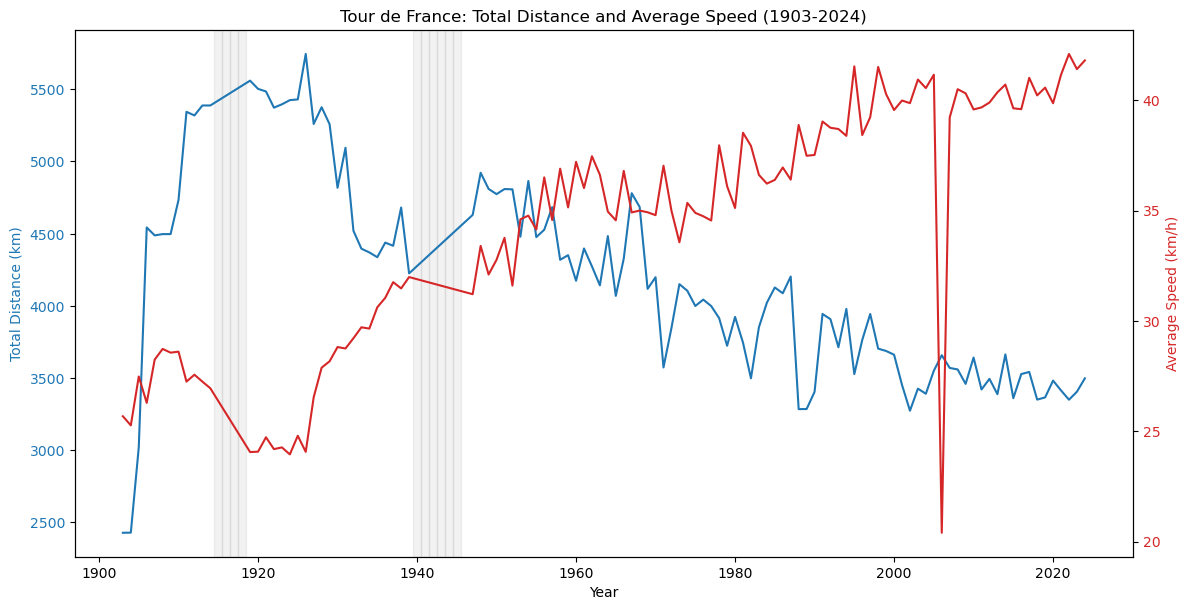

In [53]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Distance (km)', color=color1)
ax1.plot(df_all_years['Year'], df_all_years['Total_Distance_km'], color=color1, label='Total Distance (km)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Average Speed (km/h)', color=color2)
ax2.plot(df_all_years['Year'], df_all_years['Average_Speed_kmh'], color=color2, label='Average Speed (km/h)')
ax2.tick_params(axis='y', labelcolor=color2)

# Grey out missing years
missing_years = [1915, 1916, 1917, 1918, 1940, 1941, 1942, 1943, 1944, 1945]
for year in missing_years:
    ax1.axvspan(year - 0.5, year + 0.5, color='grey', alpha=0.1)

fig.tight_layout()
plt.title('Tour de France: Total Distance and Average Speed (1903-2024)')
plt.show()

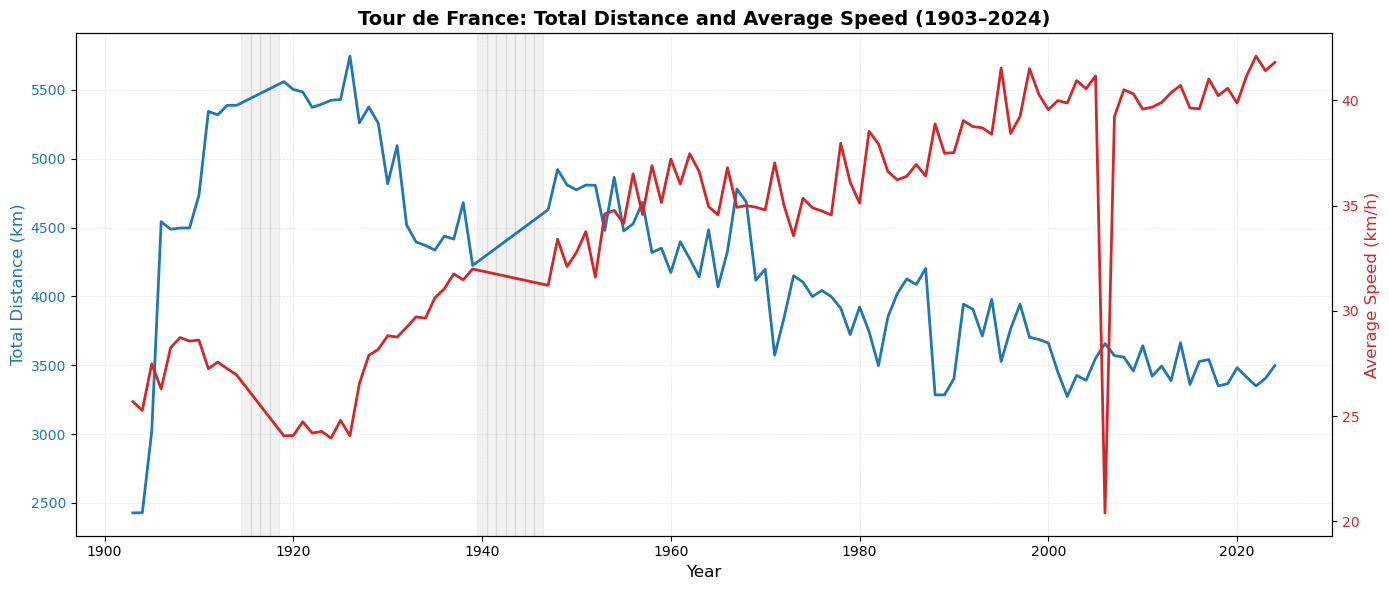

In [54]:
import matplotlib.pyplot as plt

# Filter out rows with missing values for each metric
df_dist = df_all_years.dropna(subset=['Total_Distance_km'])
df_speed = df_all_years.dropna(subset=['Average_Speed_kmh'])

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Total Distance
color1 = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Distance (km)', color=color1, fontsize=12)
ax1.plot(df_dist['Year'], df_dist['Total_Distance_km'], color=color1, label='Total Distance (km)', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Plot Average Speed on second axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Average Speed (km/h)', color=color2, fontsize=12)
ax2.plot(df_speed['Year'], df_speed['Average_Speed_kmh'], color=color2, label='Average Speed (km/h)', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add light grid
ax1.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.3)

# Highlight missing years
missing_years = [1915, 1916, 1917, 1918, 1940, 1941, 1942, 1943, 1944, 1945, 1946]
for year in missing_years:
    ax1.axvspan(year - 0.5, year + 0.5, color='grey', alpha=0.1)

# Title and layout
plt.title('Tour de France: Total Distance and Average Speed (1903–2024)', fontsize=14, weight='bold')
fig.tight_layout()
plt.show()


## Scrape participants table from 2014 to 2024 from procyclingstats.com

In [55]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

years = list(range(2014, 2025))  # 2014 to 2024 inclusive
cols = ['Year', 'Rnk', 'Specialty', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time']
all_data = []

for year in years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/gc"
    print(f"Scraping GC {year}...", end=" ")

    try:
        resp = requests.get(url, timeout=15)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, 'html.parser')

        # Locate the GC table
        table = soup.select_one('table.basic')
        if not table:
            print("Table not found.")
            continue

        headers = [th.text.strip() for th in table.select('thead th')]
        # Expected: ['Rnk', 'Specialty', 'Rider', 'Team', 'UCI', 'Pts', 'Time', 'Gap', ...]
        mapping = {}
        for idx, h in enumerate(headers):
            key = h
            if h in ['Rnk', 'Specialty', 'Rider', 'Age', 'Team', 'UCI', 'P', 'Time']:
                mapping[idx] = {'Rnk':'Rnk', 'Specialty':'Specialty',
                                'Rider':'Rider', 'Age':'Age', 'Team':'Team',
                                'UCI':'UCI', 'P':'Pnt', 'Time':'Time'}[h]

        for row in table.select('tbody tr'):
            cells = row.select('td')
            record = {'Year': year}
            for idx, cell in enumerate(cells):
                if idx in mapping:
                    field = mapping[idx]
                    record[field] = cell.text.strip()
            # Keep only records with a rank
            if 'Rnk' in record and record['Rnk']:
                all_data.append(record)

        print(f"{len(table.select('tbody tr'))} rows.")
    except Exception as e:
        print(f"Error: {e}")
        continue

    time.sleep(1.5)

df_2014_2024 = pd.DataFrame(all_data, columns=cols)
df_2014_2024.to_csv("tdf_gc_2014_2024.csv", index=False)
print("\n✅ Scraping complete. Saved to 'tdf_gc_2014_2024.csv'.")


Scraping GC 2014... 164 rows.
Scraping GC 2015... 160 rows.
Scraping GC 2016... 175 rows.
Scraping GC 2017... 167 rows.
Scraping GC 2018... 145 rows.
Scraping GC 2019... 155 rows.
Scraping GC 2020... 146 rows.
Scraping GC 2021... 142 rows.
Scraping GC 2022... 138 rows.
Scraping GC 2023... 150 rows.
Scraping GC 2024... 141 rows.

✅ Scraping complete. Saved to 'tdf_gc_2014_2024.csv'.


In [56]:
df_2014_2024.tail(50)

,Year,Rnk,Specialty,Rider,Age,Team,UCI,Pnt,Time
1633,2024,92,Sprint,COQUARD Bryan Cofidis,32,Cofidis,,NaN,7:067:06
1634,2024,93,Classic,ABRAHAMSEN Jonas Uno-X Mobility,28,Uno-X Mobility,,NaN,",,7:06"
1635,2024,94,Classic,ZIMMERMANN Georg Intermarché - Wanty,26,Intermarché - Wanty,,NaN,7:077:07
1636,2024,95,Classic,REX Laurenz Intermarché - Wanty,24,Intermarché - Wanty,,NaN,7:097:09
1637,2024,96,Hills,CORT Magnus Uno-X Mobility,31,Uno-X Mobility,,NaN,",,7:09"
1638,2024,97,GC,POELS Wout Bahrain - Victorious,36,Bahrain - Victorious,,NaN,7:157:15
1639,2024,98,GC,EIKING Odd Christian Uno-X Mobility,29,Uno-X Mobility,,NaN,7:187:18
1640,2024,99,Sprint,VAN POPPEL Danny Red Bull - BORA - hansgrohe,30,Red Bull - BORA - hansgrohe,,NaN,7:207:20
1641,2024,100,GC,DRIZNERS Jarrad Lotto Dstny,25,Lotto Dstny,,NaN,7:257:25
1642,2024,101,Classic,VERMEERSCH Gianni Alpecin - Deceuninck,31,Alpecin - Deceuninck,,NaN,7:297:29


In [ ]:
# Script is scraping the wrong table (https://www.procyclingstats.com/race/tour-de-france/2024/stage-21)
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

years = list(range(2014, 2025))  # 2014 to 2024 inclusive
cols = ['Year', 'Rnk', 'Specialty', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time']
all_data = []

for year in years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/gc"
    print(f"Scraping GC {year}...", end=" ")

    try:
        resp = requests.get(url, timeout=15)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, 'html.parser')

        # Find the GC table
        table = soup.select_one('table.basic')
        if not table:
            print("❌ Table not found.")
            continue

        # Extract headers to locate the column indexes we care about
        headers = [th.text.strip() for th in table.select('thead th')]
        mapping = {}
        for idx, h in enumerate(headers):
            header_map = {
                'Rnk': 'Rnk',
                'Specialty': 'Specialty',
                'Rider': 'Rider',
                'Age': 'Age',
                'Team': 'Team',
                'UCI': 'UCI',
                'P': 'Pnt',
                'Time': 'Time'
            }
            if h in header_map:
                mapping[idx] = header_map[h]

        # Extract rows
        for row in table.select('tbody tr'):
            cells = row.select('td')
            record = {'Year': year}
            for idx, cell in enumerate(cells):
                if idx in mapping:
                    record[mapping[idx]] = cell.text.strip()
            # Only keep rows with valid rank
            if 'Rnk' in record and record['Rnk']:
                all_data.append(record)

        print(f"{len(table.select('tbody tr'))} rows.")

    except Exception as e:
        print(f"❌ Error: {e}")
        continue

    time.sleep(1.5)  # Respectful delay

# Create DataFrame and save
df_2014_2024 = pd.DataFrame(all_data, columns=cols)
df_2014_2024.to_csv("tdf_gc_2014_2024.csv", index=False)

print("\n✅ Scraping complete. Saved to 'tdf_gc_2014_2024.csv'.")


Scraping GC 2014... 164 rows.
Scraping GC 2015... 160 rows.
Scraping GC 2016... 175 rows.
Scraping GC 2017... 167 rows.
Scraping GC 2018... 145 rows.
Scraping GC 2019... 155 rows.
Scraping GC 2020... 146 rows.
Scraping GC 2021... 142 rows.
Scraping GC 2022... 138 rows.
Scraping GC 2023... 150 rows.
Scraping GC 2024... 141 rows.

✅ Scraping complete. Saved to 'tdf_gc_2014_2024.csv'.


In [58]:
df_2014_2024.head()

,Year,Rnk,Specialty,Rider,Age,Team,UCI,Pnt,Time
0,2014,1,Sprint,KITTEL Marcel Team Giant - Shimano,26,Team Giant - Shimano,20,NaN,3:20:50
1,2014,2,Classic,KRISTOFF Alexander Team Katusha,27,Team Katusha,10,NaN,",,0:00"
2,2014,3,TT,NAVARDAUSKAS Ramūnas Garmin Sharp,26,Garmin Sharp,6,NaN,",,0:00"
3,2014,4,Sprint,GREIPEL André Lotto Belisol,32,Lotto Belisol,4,NaN,",,0:00"
4,2014,5,Classic,RENSHAW Mark Omega Pharma - Quick-Step,31,Omega Pharma - Quick-Step,2,NaN,",,0:00"


In [ ]:
# Script is scraping the wrong table (https://www.procyclingstats.com/race/tour-de-france/2024/stage-21)
import requests
from bs4 import BeautifulSoup

url = "https://www.procyclingstats.com/race/tour-de-france/2014/gc"
resp = requests.get(url)
resp.raise_for_status()
soup = BeautifulSoup(resp.content, 'html.parser')

table = soup.select_one('table.basic')
if not table:
    print("Table not found")
else:
    headers = [th.text.strip() for th in table.select('thead th')]
    print("Headers:", headers)
    
    # Print first 3 rows
    rows = table.select('tbody tr')
    for row in rows[:3]:
        cells = [td.text.strip() for td in row.select('td')]
        print(cells)


Headers: ['Rnk', 'GC', 'Timelag', 'BIB', 'H2H', 'Specialty', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', '', 'Time']
['1', '161', '+5:06:27', '101', '', 'Sprint', 'KITTEL Marcel Team Giant - Shimano', '26', 'Team Giant - Shimano', '20', '100', '', '3:20:50']
['2', '125', '+4:11:46', '23', '', 'Classic', 'KRISTOFF Alexander Team Katusha', '27', 'Team Katusha', '10', '70', '', ',,0:00']
['3', '141', '+4:37:42', '97', '', 'TT', 'NAVARDAUSKAS Ramūnas Garmin Sharp', '26', 'Garmin Sharp', '6', '50', '', ',,0:00']


In [60]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

years = list(range(2014, 2025))
all_data = []

for year in years:
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/gc"
    print(f"Scraping {year}...", end=" ")

    try:
        resp = requests.get(url)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, 'html.parser')

        # Find the GC results table
        table = soup.find('table', class_='basic')
        if not table:
            print("No table found")
            continue

        # The header to confirm columns (just print for debug)
        headers = [th.text.strip() for th in table.find('thead').find_all('th')]
        # Expected headers: ['Rnk', 'Prev', '▼▲', 'Rider', 'Team', 'Pnt', 'Time']
        # print("Headers:", headers)

        rows = table.find('tbody').find_all('tr')

        for row in rows:
            cols = row.find_all('td')
            if len(cols) < 7:
                # Skip incomplete rows or separators
                continue

            rnk = cols[0].text.strip()
            prev = cols[1].text.strip()
            up_down = cols[2].text.strip()
            
            # Rider name may contain newlines and spaces, get text only
            rider = cols[3].get_text(separator=" ", strip=True)
            team = cols[4].get_text(separator=" ", strip=True)
            pnt = cols[5].text.strip()
            time_val = cols[6].text.strip()

            all_data.append({
                'Year': year,
                'Rnk': rnk,
                'Prev': prev,
                'Up/Down': up_down,
                'Rider': rider,
                'Team': team,
                'Pnt': pnt,
                'Time': time_val
            })

        print(f"{len(rows)} rows")

    except Exception as e:
        print(f"Error scraping year {year}: {e}")

    time.sleep(1.5)  # Be polite to the server

df_2014_2024 = pd.DataFrame(all_data)
df_2014_2024.to_csv("tdf_gc_2014_2024.csv", index=False)
print("Saved to tdf_gc_2014_2024.csv")


Scraping 2014... 164 rows
Scraping 2015... 160 rows
Scraping 2016... 175 rows
Scraping 2017... 167 rows
Scraping 2018... 145 rows
Scraping 2019... 155 rows
Scraping 2020... 146 rows
Scraping 2021... 142 rows
Scraping 2022... 138 rows
Scraping 2023... 150 rows
Scraping 2024... 141 rows
Saved to tdf_gc_2014_2024.csv


In [ ]:
# Script is scraping the wrong table (https://www.procyclingstats.com/race/tour-de-france/2024/stage-21)
import requests
import pandas as pd

url = "https://www.procyclingstats.com/race/tour-de-france/2014/gc"

# 1. Fetch the HTML content
response = requests.get(url)
response.raise_for_status()  # will raise an error if request fails

# 2. Use pandas to parse all tables on the page
tables = pd.read_html(response.text)

print(f"Found {len(tables)} tables on the page")

# 3. Identify the GC table by its columns
gc_table = None
for table in tables:
    # Looking for expected columns in the GC table
    expected_cols = {'Rnk', 'Rider', 'Age', 'Team', 'Time'}
    if expected_cols.issubset(table.columns):
        gc_table = table
        break

if gc_table is None:
    print("Could not find the GC table.")
else:
    print("GC table found!")
    print(gc_table.head())

    # Optional: save to CSV for later use
    gc_table.to_csv("tour_de_france_2014_gc.csv", index=False)


Found 6 tables on the page
GC table found!
   Rnk   GC   Timelag  BIB  H2H Specialty                                   Rider  Age                       Team   UCI    Pnt  Unnamed: 11     Time
0    1  161  +5:06:27  101  NaN    Sprint      KITTEL Marcel Team Giant - Shimano   26       Team Giant - Shimano  20.0  100.0          NaN  3:20:50
1    2  125  +4:11:46   23  NaN   Classic         KRISTOFF Alexander Team Katusha   27               Team Katusha  10.0   70.0          NaN   ,,0:00
2    3  141  +4:37:42   97  NaN        TT       NAVARDAUSKAS Ramūnas Garmin Sharp   26               Garmin Sharp   6.0   50.0          NaN   ,,0:00
3    4  149  +4:44:54  135  NaN    Sprint             GREIPEL André Lotto Belisol   32              Lotto Belisol   4.0   40.0          NaN   ,,0:00
4    5  142  +4:39:03   77  NaN   Classic  RENSHAW Mark Omega Pharma - Quick-Step   31  Omega Pharma - Quick-Step   2.0   32.0          NaN   ,,0:00


C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\209175052.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [62]:
pip install selenium


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Script is scraping the wrong table (https://www.procyclingstats.com/race/tour-de-france/2024/stage-21)
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

url = "https://www.procyclingstats.com/race/tour-de-france/2014/gc"

options = Options()
options.headless = True  # run without opening a browser window

driver = webdriver.Chrome(options=options)
driver.get(url)

time.sleep(5)  # wait for JS to load table

html = driver.page_source

driver.quit()

tables = pd.read_html(html)

# Find the GC table as before
for table in tables:
    if {'Rnk', 'Rider', 'Age', 'Team', 'Time'}.issubset(table.columns):
        gc_table = table
        break

print(gc_table.head())


   Rnk   GC   Timelag  BIB  H2H Specialty                                   Rider  Age                       Team   UCI    Pnt  Unnamed: 11     Time
0    1  161  +5:06:27  101  NaN    Sprint      KITTEL Marcel Team Giant - Shimano   26       Team Giant - Shimano  20.0  100.0          NaN  3:20:50
1    2  125  +4:11:46   23  NaN   Classic         KRISTOFF Alexander Team Katusha   27               Team Katusha  10.0   70.0          NaN   ,,0:00
2    3  141  +4:37:42   97  NaN        TT       NAVARDAUSKAS Ramūnas Garmin Sharp   26               Garmin Sharp   6.0   50.0          NaN   ,,0:00
3    4  149  +4:44:54  135  NaN    Sprint             GREIPEL André Lotto Belisol   32              Lotto Belisol   4.0   40.0          NaN   ,,0:00
4    5  142  +4:39:03   77  NaN   Classic  RENSHAW Mark Omega Pharma - Quick-Step   31  Omega Pharma - Quick-Step   2.0   32.0          NaN   ,,0:00


C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\2737042881.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


## Scrape participants list

In [65]:
pip install procyclingstats

Note: you may need to restart the kernel to use updated packages.


In [66]:
from procyclingstats import RaceStartlist

# Load the 2025 startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Print one sample to inspect structure
print(riders[0])



{'rider_name': 'CARAPAZ Richard', 'rider_url': 'rider/richard-carapaz', 'nationality': 'EC', 'rider_number': None, 'team_name': 'EF Education - EasyPost (WT)', 'team_url': 'team/ef-education-easypost-2025'}


In [67]:
from procyclingstats import RaceStartlist
import pandas as pd

# Load 2025 TdF startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

for r in riders:
    rider_data.append({
        'name': r.get('rider_name'),
        'rider_url': r.get('rider_url').replace('rider/', ''),  # cleaner URL
        'team': r.get('team_name'),
        'team_url': r.get('team_url'),
        'bib_number': r.get('rider_number'),
        'nationality': r.get('nationality')
    })

# Create DataFrame
df_startlist = pd.DataFrame(rider_data)
df_startlist.to_csv("tdf_2025_startlist_clean.csv", index=False)

# Preview
print(df_startlist.head())


              name        rider_url                          team                         team_url bib_number nationality
0  CARAPAZ Richard  richard-carapaz  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          EC
1     SWEENY Harry     harry-sweeny  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          AU
2  POWLESS Neilson  neilson-powless  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          US
3        HEALY Ben        ben-healy  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          IE
4    POGAČAR Tadej    tadej-pogacar  UAE Team Emirates - XRG (WT)  team/uae-team-emirates-xrg-2025       None          SI


In [68]:
import requests

def test_rider_url(rider_url):
    full_url = 'https://www.procyclingstats.com/' + rider_url
    r = requests.get(full_url)
    print(f"{full_url} -> status: {r.status_code}")
    return r.status_code == 200

# Example test
print(test_rider_url('rider/richard-carapaz'))  # Should print 200


https://www.procyclingstats.com/rider/richard-carapaz -> status: 200
True


In [69]:
from procyclingstats import RaceStartlist, Rider
import pandas as pd

# Load 2025 TdF startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

for r in riders:
    rider_name = r.get('rider_name')
    rider_url_suffix = r.get('rider_url').replace('rider/', '') 
    team_name = r.get('team_name')
    team_url = r.get('team_url')
    bib_number = r.get('rider_number')
    nationality = r.get('nationality')

    # Create a Rider object for the current rider
    try:
        rider_profile = Rider(f"rider/{rider_url_suffix}")
        
        # Extract additional information
        birthdate = rider_profile.birthdate()
        place_of_birth = rider_profile.place_of_birth()
        height = rider_profile.height()
        weight = rider_profile.weight()
        # You can explore other methods from the Rider class in the documentation:
        # https://procyclingstats.readthedocs.io/en/stable/api.html#procyclingstats.Rider

    except Exception as e:
        print(f"Error scraping data for {rider_name} ({rider_url_suffix}): {e}")
        # Set values to None or a default if scraping fails for a rider
        birthdate = None
        place_of_birth = None
        height = None
        weight = None

    rider_data.append({
        'name': rider_name,
        'rider_url': rider_url_suffix,
        'team': team_name,
        'team_url': team_url,
        'bib_number': bib_number,
        'nationality': nationality,
        'birthdate': birthdate,
        'place_of_birth': place_of_birth,
        'height': height,
        'weight': weight
    })

# Create DataFrame
df_startlist_extended = pd.DataFrame(rider_data)
df_startlist_extended.to_csv("tdf_2025_startlist_extended.csv", index=False)

# Preview
print(df_startlist_extended.head())

              name        rider_url                          team                         team_url bib_number nationality  birthdate place_of_birth  height  weight
0  CARAPAZ Richard  richard-carapaz  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          EC  1993-5-29     El Carmelo    1.70    62.0
1     SWEENY Harry     harry-sweeny  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          AU   1998-7-9        Warwick    1.86    75.0
2  POWLESS Neilson  neilson-powless  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          US   1996-9-3          Eglin    1.83    67.0
3        HEALY Ben        ben-healy  EF Education - EasyPost (WT)  team/ef-education-easypost-2025       None          IE  2000-9-11   Kingswinford    1.75    65.0
4    POGAČAR Tadej    tadej-pogacar  UAE Team Emirates - XRG (WT)  team/uae-team-emirates-xrg-2025       None          SI  1998-9-21         Klanec    1.76    66.0


In [70]:
startlist_2025 = pd.read_csv("tdf_2025_startlist_extended.csv")
startlist_2025.head()

,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight
0,CARAPAZ Richard,richard-carapaz,EF Education - EasyPost (WT),team/ef-education-easypost-2025,NaN,EC,1993-5-29,El Carmelo,1.70,62.0
1,SWEENY Harry,harry-sweeny,EF Education - EasyPost (WT),team/ef-education-easypost-2025,NaN,AU,1998-7-9,Warwick,1.86,75.0
2,POWLESS Neilson,neilson-powless,EF Education - EasyPost (WT),team/ef-education-easypost-2025,NaN,US,1996-9-3,Eglin,1.83,67.0
3,HEALY Ben,ben-healy,EF Education - EasyPost (WT),team/ef-education-easypost-2025,NaN,IE,2000-9-11,Kingswinford,1.75,65.0
4,POGAČAR Tadej,tadej-pogacar,UAE Team Emirates - XRG (WT),team/uae-team-emirates-xrg-2025,NaN,SI,1998-9-21,Klanec,1.76,66.0


In [71]:
from procyclingstats import RaceStartlist, Rider, Ranking
import pandas as pd
import time

# Load 2025 TdF startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

# --- Get current rankings for PCS and UCI World (once) ---
# These rankings are not directly on the rider profile, but are global rankings.
# We'll fetch them once and then look up each rider's rank.
# Note: These rankings are dynamic and reflect the current date.
# For historical ranks, you'd need to specify a date to the Ranking object if supported,
# or scrape historical ranking pages.
try:
    pcs_ranking_men = Ranking("rankings/me/individual").parse()
    uci_ranking_men = Ranking("rankings/me/uci-individual").parse()
except Exception as e:
    print(f"Error fetching global rankings: {e}")
    pcs_ranking_men = []
    uci_ranking_men = []

# Convert rankings to dictionaries for faster lookup
pcs_rank_lookup = {r['rider_url'].replace('rider/', ''): r['rank'] for r in pcs_ranking_men if 'rider_url' in r and 'rank' in r}
uci_rank_lookup = {r['rider_url'].replace('rider/', ''): r['rank'] for r in uci_ranking_men if 'rider_url' in r and 'rank' in r}


for i, r in enumerate(riders):
    rider_name = r.get('rider_name')
    rider_url_suffix = r.get('rider_url').replace('rider/', '')
    team_name = r.get('team_name')
    team_url = r.get('team_url')
    bib_number = r.get('rider_number')
    nationality = r.get('nationality')

    # Initialize new fields
    birthdate = None
    place_of_birth = None
    height = None
    weight = None
    points_per_speciality = {} # This will store a dictionary of specialities and their points
    pcs_rank = None
    uci_world_rank = None

    print(f"Processing rider {i+1}/{len(riders)}: {rider_name}")

    # Add a small delay to be polite and avoid being blocked
    time.sleep(0.5) # Wait for 0.5 seconds between each rider profile request

    try:
        rider_profile = Rider(f"rider/{rider_url_suffix}")

        birthdate = rider_profile.birthdate()
        place_of_birth = rider_profile.place_of_birth()
        height = rider_profile.height()
        weight = rider_profile.weight()

        # Points per speciality
        # The .points_per_speciality() method returns a dictionary
        points_per_speciality = rider_profile.points_per_speciality()

        # Lookup PCS and UCI World ranks from the pre-fetched global rankings
        pcs_rank = pcs_rank_lookup.get(rider_url_suffix)
        uci_world_rank = uci_rank_lookup.get(rider_url_suffix)

    except Exception as e:
        print(f"Error scraping data for {rider_name} ({rider_url_suffix}): {e}")
        # Fields remain None or empty dict if an error occurs

    rider_data.append({
        'name': rider_name,
        'rider_url': rider_url_suffix,
        'team': team_name,
        'team_url': team_url,
        'bib_number': bib_number,
        'nationality': nationality,
        'birthdate': birthdate,
        'place_of_birth': place_of_birth,
        'height': height,
        'weight': weight,
        'points_per_speciality': points_per_speciality, # Store as a dictionary
        'pcs_rank': pcs_rank,
        'uci_world_rank': uci_world_rank
    })

# Create DataFrame
df_startlist_extended = pd.DataFrame(rider_data)

# You might want to normalize the 'points_per_speciality' column
# if you want each specialty to be its own column in the DataFrame.
# For example:
df_specialities = pd.json_normalize(df_startlist_extended['points_per_speciality'])
df_startlist_extended = pd.concat([df_startlist_extended.drop('points_per_speciality', axis=1), df_specialities], axis=1)


df_startlist_extended.to_csv("tdf_2025_startlist_full_details.csv", index=False)

# Preview
print(df_startlist_extended.head())
print(df_startlist_extended.columns)

Processing rider 1/117: CARAPAZ Richard
Processing rider 2/117: SWEENY Harry
Processing rider 3/117: POWLESS Neilson
Processing rider 4/117: HEALY Ben
Processing rider 5/117: POGAČAR Tadej
Processing rider 6/117: ALMEIDA João
Processing rider 7/117: YATES Adam
Processing rider 8/117: SIVAKOV Pavel
Processing rider 9/117: SOLER Marc
Processing rider 10/117: WELLENS Tim
Processing rider 11/117: NARVÁEZ Jhonatan
Processing rider 12/117: NOVAK Domen
Processing rider 13/117: POLITT Nils
Processing rider 14/117: GALL Felix
Processing rider 15/117: ROGLIČ Primož
Processing rider 16/117: MARTÍNEZ Daniel Felipe
Processing rider 17/117: VLASOV Aleksandr
Processing rider 18/117: TRATNIK Jan
Processing rider 19/117: VAN POPPEL Danny
Processing rider 20/117: LIPOWITZ Florian
Processing rider 21/117: EVENEPOEL Remco
Processing rider 22/117: MERLIER Tim
Processing rider 23/117: VAN LERBERGHE Bert
Processing rider 24/117: EENKHOORN Pascal
Processing rider 25/117: PARET-PEINTRE Valentin
Processing ride

In [72]:
df_startlist_extended.head()

,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,pcs_rank,uci_world_rank,one_day_races,gc,time_trial,sprint,climber,hills
0,CARAPAZ Richard,richard-carapaz,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,EC,1993-5-29,El Carmelo,1.70,62.0,None,None,1262,4060,551,88,4822,1735
1,SWEENY Harry,harry-sweeny,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,AU,1998-7-9,Warwick,1.86,75.0,None,None,177,228,159,63,107,251
2,POWLESS Neilson,neilson-powless,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,US,1996-9-3,Eglin,1.83,67.0,None,None,2607,1569,891,238,1678,1109
3,HEALY Ben,ben-healy,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,IE,2000-9-11,Kingswinford,1.75,65.0,None,None,1284,504,470,40,957,480
4,POGAČAR Tadej,tadej-pogacar,UAE Team Emirates - XRG (WT),team/uae-team-emirates-xrg-2025,None,SI,1998-9-21,Klanec,1.76,66.0,None,None,7677,6844,2703,194,8498,3706


In [ ]:
# Full participant list with missing ranks
from procyclingstats import RaceStartlist, Rider, Ranking
import pandas as pd
import time

# Load 2025 TdF startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

# --- Get current global rankings for PCS and UCI World (once) ---
# These rankings are dynamic and reflect the current date.
# For historical ranks, you'd need to specify a date to the Ranking object if supported,
# or scrape historical ranking pages.
try:
    print("Fetching global PCS ranking...")
    pcs_ranking_men = Ranking("rankings/me/individual").parse()
    print("Fetching global UCI World ranking...")
    uci_ranking_men = Ranking("rankings/me/uci-individual").parse()
except Exception as e:
    print(f"Error fetching global rankings: {e}")
    pcs_ranking_men = []
    uci_ranking_men = []

# Convert rankings to dictionaries for faster lookup
pcs_rank_lookup = {r['rider_url'].replace('rider/', ''): r['rank'] for r in pcs_ranking_men if 'rider_url' in r and 'rank' in r}
uci_rank_lookup = {r['rider_url'].replace('rider/', ''): r['rank'] for r in uci_ranking_men if 'rider_url' in r and 'rank' in r}

# Print a few to debug if needed
# print("\nSample PCS lookup:", {k: pcs_rank_lookup[k] for k in list(pcs_rank_lookup)[:5]})
# print("Sample UCI lookup:", {k: uci_rank_lookup[k] for k in list(uci_rank_lookup)[:5]})


for i, r in enumerate(riders):
    rider_name = r.get('rider_name')
    rider_url_suffix = r.get('rider_url').replace('rider/', '')
    team_name = r.get('team_name')
    team_url = r.get('team_url')
    bib_number = r.get('rider_number')
    nationality = r.get('nationality')

    # Initialize new fields
    birthdate = None
    place_of_birth = None
    height = None
    weight = None
    points_per_speciality = {}
    pcs_rank = None
    uci_world_rank = None
    all_time_rank = None # Will likely remain None with current library capabilities for 'All time'

    print(f"Processing rider {i+1}/{len(riders)}: {rider_name}")

    # Add a small delay to be polite and avoid being blocked
    time.sleep(0.5) # Wait for 0.5 seconds between each rider profile request

    try:
        rider_profile = Rider(f"rider/{rider_url_suffix}")

        birthdate = rider_profile.birthdate()
        place_of_birth = rider_profile.place_of_birth()
        height = rider_profile.height()
        weight = rider_profile.weight()

        # Points per speciality (this method *does* exist and works)
        points_per_speciality = rider_profile.points_per_speciality()

        # Lookup PCS and UCI World ranks from the pre-fetched global rankings
        # These will reflect their current rank on the global list.
        pcs_rank = pcs_rank_lookup.get(rider_url_suffix)
        uci_world_rank = uci_rank_lookup.get(rider_url_suffix)

        # As established, 'pcs_rank()' method does not exist on Rider object.
        # To get 'All time' rank, you would need to implement direct HTML parsing
        # or hope for a future library update. For now, it will remain None.

    except Exception as e:
        print(f"Error scraping data for {rider_name} ({rider_url_suffix}): {e}")
        # Fields remain None or empty dict if an error occurs

    rider_data.append({
        'name': rider_name,
        'rider_url': rider_url_suffix,
        'team': team_name,
        'team_url': team_url,
        'bib_number': bib_number,
        'nationality': nationality,
        'birthdate': birthdate,
        'place_of_birth': place_of_birth,
        'height': height,
        'weight': weight,
        'points_per_speciality': points_per_speciality, # Store as a dictionary
        'pcs_rank': pcs_rank, # Global PCS Rank (will be None if not found in current global list)
        'uci_world_rank': uci_world_rank, # Global UCI World Rank (will be None if not found in current global list)
        'all_time_rank': all_time_rank # Will likely be None as there's no direct method in the library
    })

# Create DataFrame
df_startlist_extended = pd.DataFrame(rider_data)

# Normalize the 'points_per_speciality' column if it's not empty
if not df_startlist_extended['points_per_speciality'].empty:
    df_specialities = pd.json_normalize(df_startlist_extended['points_per_speciality'])
    df_startlist_extended = pd.concat([df_startlist_extended.drop('points_per_speciality', axis=1), df_specialities], axis=1)

df_startlist_extended.to_csv("tdf_2025_startlist_full_details_corrected.csv", index=False)

# Preview
print(df_startlist_extended.head())
print(df_startlist_extended.columns)

Fetching global PCS ranking...
Fetching global UCI World ranking...
Processing rider 1/117: CARAPAZ Richard
Processing rider 2/117: SWEENY Harry
Processing rider 3/117: POWLESS Neilson
Processing rider 4/117: HEALY Ben
Processing rider 5/117: POGAČAR Tadej
Processing rider 6/117: ALMEIDA João
Processing rider 7/117: YATES Adam
Processing rider 8/117: SIVAKOV Pavel
Processing rider 9/117: SOLER Marc
Processing rider 10/117: WELLENS Tim
Processing rider 11/117: NARVÁEZ Jhonatan
Processing rider 12/117: NOVAK Domen
Processing rider 13/117: POLITT Nils
Processing rider 14/117: GALL Felix
Processing rider 15/117: ROGLIČ Primož
Processing rider 16/117: MARTÍNEZ Daniel Felipe
Processing rider 17/117: VLASOV Aleksandr
Processing rider 18/117: TRATNIK Jan
Processing rider 19/117: VAN POPPEL Danny
Processing rider 20/117: LIPOWITZ Florian
Processing rider 21/117: EVENEPOEL Remco
Processing rider 22/117: MERLIER Tim
Processing rider 23/117: VAN LERBERGHE Bert
Processing rider 24/117: EENKHOORN Pa

In [74]:
df_startlist_extended.head()

,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,pcs_rank,uci_world_rank,all_time_rank,one_day_races,gc,time_trial,sprint,climber,hills
0,CARAPAZ Richard,richard-carapaz,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,EC,1993-5-29,El Carmelo,1.70,62.0,None,None,None,1262,4060,551,88,4822,1735
1,SWEENY Harry,harry-sweeny,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,AU,1998-7-9,Warwick,1.86,75.0,None,None,None,177,228,159,63,107,251
2,POWLESS Neilson,neilson-powless,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,US,1996-9-3,Eglin,1.83,67.0,None,None,None,2607,1569,891,238,1678,1109
3,HEALY Ben,ben-healy,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,IE,2000-9-11,Kingswinford,1.75,65.0,None,None,None,1284,504,470,40,957,480
4,POGAČAR Tadej,tadej-pogacar,UAE Team Emirates - XRG (WT),team/uae-team-emirates-xrg-2025,None,SI,1998-9-21,Klanec,1.76,66.0,None,None,None,7677,6844,2703,194,8498,3706


In [ ]:
# Full participant list with missing ranks
from procyclingstats import RaceStartlist, Rider
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup

# Load 2025 TdF startlist
# Using a specific past year (e.g., 2024) might be better for testing
# to ensure riders have current ranks, but 2025 will work if the list exists.
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

PCS_BASE_URL = "https://www.procyclingstats.com/"

# Add a User-Agent header to mimic a real browser.
# Some websites block requests without a proper User-Agent.
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

for i, r in enumerate(riders):
    rider_name = r.get('rider_name')
    rider_url_suffix = r.get('rider_url').replace('rider/', '') # e.g., "richard-carapaz"
    team_name = r.get('team_name')
    team_url = r.get('team_url')
    bib_number = r.get('rider_number')
    nationality = r.get('nationality')

    # Initialize new fields
    birthdate = None
    place_of_birth = None
    height = None
    weight = None
    points_per_speciality = {}
    all_time_rank = None
    uci_world_rank = None
    pcs_rank = None

    print(f"Processing rider {i+1}/{len(riders)}: {rider_name}")

    # Add a delay before making the Rider object request AND the direct HTML request
    time.sleep(0.75) # Adjust as needed, be polite to the server

    try:
        # Use the procyclingstats library for the data it can provide
        rider_profile_lib = Rider(f"rider/{rider_url_suffix}")
        birthdate = rider_profile_lib.birthdate()
        place_of_birth = rider_profile_lib.place_of_birth()
        height = rider_profile_lib.height()
        weight = rider_profile_lib.weight()
        points_per_speciality = rider_profile_lib.points_per_speciality()

    except Exception as e:
        print(f"Error getting base data for {rider_name} ({rider_url_suffix}) with procyclingstats library: {e}")

    # === NEW AND IMPROVED: Direct HTML scraping for ranks ===
    rider_profile_url = f"{PCS_BASE_URL}rider/{rider_url_suffix}"
    try:
        response = requests.get(rider_profile_url, headers=HEADERS) # Pass headers
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all <div> tags with class "rnk"
        rank_divs = soup.find_all('div', class_='rnk')

        for rnk_div in rank_divs:
            # Inside each "rnk" div, find the strong tag which usually holds the rank type
            rank_type_tag = rnk_div.find('strong')
            # The rank value itself is usually in an <a> tag directly after the strong tag,
            # or in the text of the rnk_div itself if it's not a link.
            # Let's target the <a> tag first as it seems common for PCS/UCI/All time
            rank_value_tag = rnk_div.find('a')

            if rank_type_tag and rank_value_tag:
                rank_type = rank_type_tag.get_text(strip=True)
                rank_value = rank_value_tag.get_text(strip=True) # Get the text from the <a> tag

                if rank_type == 'All time':
                    all_time_rank = rank_value
                elif rank_type == 'UCI World':
                    uci_world_rank = rank_value
                elif rank_type == 'PCS Ranking':
                    pcs_rank = rank_value
            elif rank_type_tag: # Fallback if there's no <a> tag, sometimes it's direct text
                 # Check if the text is directly in the rnk_div itself, after the strong tag
                 # This is more complex, but sometimes needed if they change structure slightly
                 # For now, let's assume it's always in an <a> tag for these specific ranks.
                 pass # If no <a> tag, we just skip for now, assuming it's not the rank we want


    except requests.exceptions.RequestException as e:
        print(f"Error fetching HTML for {rider_name} from {rider_profile_url}: {e}")
    except Exception as e:
        print(f"Error parsing HTML for {rider_name}: {e}")

    rider_data.append({
        'name': rider_name,
        'rider_url': rider_url_suffix,
        'team': team_name,
        'team_url': team_url,
        'bib_number': bib_number,
        'nationality': nationality,
        'birthdate': birthdate,
        'place_of_birth': place_of_birth,
        'height': height,
        'weight': weight,
        'points_per_speciality': points_per_speciality,
        'all_time_rank': all_time_rank,
        'uci_world_rank': uci_world_rank,
        'pcs_rank': pcs_rank
    })

# Create DataFrame
df_startlist_extended = pd.DataFrame(rider_data)

# Normalize the 'points_per_speciality' column if it's not empty
if not df_startlist_extended['points_per_speciality'].empty:
    df_specialities = pd.json_normalize(df_startlist_extended['points_per_speciality'])
    # Rename columns to avoid potential clashes if specialties have names like 'name' or 'team'
    df_specialities.columns = [f'speciality_{col}' for col in df_specialities.columns]
    df_startlist_extended = pd.concat([df_startlist_extended.drop('points_per_speciality', axis=1), df_specialities], axis=1)

df_startlist_extended.to_csv("tdf_2025_startlist_full_details_direct_scrape_v2.csv", index=False)

# Preview
print(df_startlist_extended.head())
print(df_startlist_extended.columns)

Processing rider 1/117: CARAPAZ Richard
Processing rider 2/117: SWEENY Harry
Processing rider 3/117: POWLESS Neilson
Processing rider 4/117: HEALY Ben
Processing rider 5/117: POGAČAR Tadej
Processing rider 6/117: ALMEIDA João
Processing rider 7/117: YATES Adam
Processing rider 8/117: SIVAKOV Pavel
Processing rider 9/117: SOLER Marc
Processing rider 10/117: WELLENS Tim
Processing rider 11/117: NARVÁEZ Jhonatan
Processing rider 12/117: NOVAK Domen
Processing rider 13/117: POLITT Nils
Processing rider 14/117: GALL Felix
Processing rider 15/117: ROGLIČ Primož
Processing rider 16/117: MARTÍNEZ Daniel Felipe
Processing rider 17/117: VLASOV Aleksandr
Processing rider 18/117: TRATNIK Jan
Processing rider 19/117: VAN POPPEL Danny
Processing rider 20/117: LIPOWITZ Florian
Processing rider 21/117: EVENEPOEL Remco
Processing rider 22/117: MERLIER Tim
Processing rider 23/117: VAN LERBERGHE Bert
Processing rider 24/117: EENKHOORN Pascal
Processing rider 25/117: PARET-PEINTRE Valentin
Processing ride

In [76]:
df_startlist_extended.head()

,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,all_time_rank,uci_world_rank,pcs_rank,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,CARAPAZ Richard,richard-carapaz,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,EC,1993-5-29,El Carmelo,1.70,62.0,None,None,None,1262,4060,551,88,4822,1735
1,SWEENY Harry,harry-sweeny,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,AU,1998-7-9,Warwick,1.86,75.0,None,None,None,177,228,159,63,107,251
2,POWLESS Neilson,neilson-powless,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,US,1996-9-3,Eglin,1.83,67.0,None,None,None,2607,1569,891,238,1678,1109
3,HEALY Ben,ben-healy,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,IE,2000-9-11,Kingswinford,1.75,65.0,None,None,None,1284,504,470,40,957,480
4,POGAČAR Tadej,tadej-pogacar,UAE Team Emirates - XRG (WT),team/uae-team-emirates-xrg-2025,None,SI,1998-9-21,Klanec,1.76,66.0,None,None,None,7677,6844,2703,194,8498,3706


In [ ]:
# Full participant list with missing ranks
from procyclingstats import RaceStartlist, Rider
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup

# Load 2025 TdF startlist
start = RaceStartlist("race/tour-de-france/2025/startlist")
riders = start.startlist()

# Store records
rider_data = []

PCS_BASE_URL = "https://www.procyclingstats.com/"

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

for i, r in enumerate(riders):
    rider_name = r.get('rider_name')
    rider_url_suffix = r.get('rider_url').replace('rider/', '') # e.g., "richard-carapaz"
    team_name = r.get('team_name')
    team_url = r.get('team_url')
    bib_number = r.get('rider_number')
    nationality = r.get('nationality')

    # Initialize new fields
    birthdate = None
    place_of_birth = None
    height = None
    weight = None
    points_per_speciality = {}
    all_time_rank = None
    uci_world_rank = None
    pcs_rank = None

    print(f"Processing rider {i+1}/{len(riders)}: {rider_name}")

    # Add a delay
    time.sleep(0.75) # Adjust as needed

    try:
        rider_profile_lib = Rider(f"rider/{rider_url_suffix}")
        birthdate = rider_profile_lib.birthdate()
        place_of_birth = rider_profile_lib.place_of_birth()
        height = rider_profile_lib.height()
        weight = rider_profile_lib.weight()
        points_per_speciality = rider_profile_lib.points_per_speciality()

    except Exception as e:
        print(f"Error getting base data for {rider_name} ({rider_url_suffix}) with procyclingstats library: {e}")

    # === NEW AND IMPROVED: Direct HTML scraping for ranks using CSS selectors ===
    rider_profile_url = f"{PCS_BASE_URL}rider/{rider_url_suffix}"
    try:
        response = requests.get(rider_profile_url, headers=HEADERS)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # Try to find the common parent of these rank divs/list items.
        # Based on typical PCS structure, they are often in a 'list-group' within a sidebar.
        # Let's target the list items directly
        rank_items = soup.select('ul.list-group li.list-group-item') # Select all <li> with class 'list-group-item' within a 'ul' with class 'list-group'

        for item in rank_items:
            strong_tag = item.find('strong')
            a_tag = item.find('a')

            if strong_tag and a_tag: # Ensure both tags exist
                rank_type = strong_tag.get_text(strip=True)
                rank_value = a_tag.get_text(strip=True)

                if rank_type == 'All time':
                    all_time_rank = rank_value
                elif rank_type == 'UCI World':
                    uci_world_rank = rank_value
                elif rank_type == 'PCS Ranking':
                    pcs_rank = rank_value
            # This part will be executed if strong_tag and a_tag are not both found.
            # We can print a debug message here if we suspect elements are missing.
            # else:
            #     print(f"DEBUG: Found list item but missing strong/a tag: {item.prettify()}")


    except requests.exceptions.RequestException as e:
        print(f"Error fetching HTML for {rider_name} from {rider_profile_url}: {e}")
    except Exception as e:
        print(f"Error parsing HTML for {rider_name}: {e}")

    rider_data.append({
        'name': rider_name,
        'rider_url': rider_url_suffix,
        'team': team_name,
        'team_url': team_url,
        'bib_number': bib_number,
        'nationality': nationality,
        'birthdate': birthdate,
        'place_of_birth': place_of_birth,
        'height': height,
        'weight': weight,
        'points_per_speciality': points_per_speciality,
        'all_time_rank': all_time_rank,
        'uci_world_rank': uci_world_rank,
        'pcs_rank': pcs_rank
    })

# Create DataFrame
df_startlist_extended = pd.DataFrame(rider_data)

# Normalize the 'points_per_speciality' column if it's not empty
if not df_startlist_extended['points_per_speciality'].empty:
    df_specialities = pd.json_normalize(df_startlist_extended['points_per_speciality'])
    df_specialities.columns = [f'speciality_{col}' for col in df_specialities.columns]
    df_startlist_extended = pd.concat([df_startlist_extended.drop('points_per_speciality', axis=1), df_specialities], axis=1)

df_startlist_extended.to_csv("tdf_2025_startlist_full_details_direct_scrape_v3.csv", index=False)

# Preview
print(df_startlist_extended.head())
print(df_startlist_extended.columns)

Processing rider 1/117: CARAPAZ Richard
Processing rider 2/117: SWEENY Harry
Processing rider 3/117: POWLESS Neilson
Processing rider 4/117: HEALY Ben
Processing rider 5/117: POGAČAR Tadej
Processing rider 6/117: ALMEIDA João
Processing rider 7/117: YATES Adam
Processing rider 8/117: SIVAKOV Pavel
Processing rider 9/117: SOLER Marc
Processing rider 10/117: WELLENS Tim
Processing rider 11/117: NARVÁEZ Jhonatan
Processing rider 12/117: NOVAK Domen
Processing rider 13/117: POLITT Nils
Processing rider 14/117: GALL Felix
Processing rider 15/117: ROGLIČ Primož
Processing rider 16/117: MARTÍNEZ Daniel Felipe
Processing rider 17/117: VLASOV Aleksandr
Processing rider 18/117: TRATNIK Jan
Processing rider 19/117: VAN POPPEL Danny
Processing rider 20/117: LIPOWITZ Florian
Processing rider 21/117: EVENEPOEL Remco
Processing rider 22/117: MERLIER Tim
Processing rider 23/117: VAN LERBERGHE Bert
Processing rider 24/117: EENKHOORN Pascal
Processing rider 25/117: PARET-PEINTRE Valentin
Processing ride

In [78]:
df_startlist_extended.head()

,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,all_time_rank,uci_world_rank,pcs_rank,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,CARAPAZ Richard,richard-carapaz,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,EC,1993-5-29,El Carmelo,1.70,62.0,None,None,None,1262,4060,551,88,4822,1735
1,SWEENY Harry,harry-sweeny,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,AU,1998-7-9,Warwick,1.86,75.0,None,None,None,177,228,159,63,107,251
2,POWLESS Neilson,neilson-powless,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,US,1996-9-3,Eglin,1.83,67.0,None,None,None,2607,1569,891,238,1678,1109
3,HEALY Ben,ben-healy,EF Education - EasyPost (WT),team/ef-education-easypost-2025,None,IE,2000-9-11,Kingswinford,1.75,65.0,None,None,None,1284,504,470,40,957,480
4,POGAČAR Tadej,tadej-pogacar,UAE Team Emirates - XRG (WT),team/uae-team-emirates-xrg-2025,None,SI,1998-9-21,Klanec,1.76,66.0,None,None,None,7677,6844,2703,194,8498,3706


In [79]:
# lits columns
print(df_startlist_extended.columns)

Index(['name', 'rider_url', 'team', 'team_url', 'bib_number', 'nationality', 'birthdate', 'place_of_birth', 'height', 'weight', 'all_time_rank', 'uci_world_rank', 'pcs_rank', 'speciality_one_day_races', 'speciality_gc', 'speciality_time_trial', 'speciality_sprint', 'speciality_climber', 'speciality_hills'], dtype='object')


In [ ]:
# # Code to scrape the 2025 Tour de France startlist and rider details, partially working and taking too long to run
# from procyclingstats import RaceStartlist, Rider, Ranking
# import pandas as pd
# import time
# from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException, WebDriverException

# # --- Selenium Setup ---
# # You might need to specify the path to your chromedriver.exe here
# # If it's in your PATH, you can often omit executable_path.
# # service = Service(executable_path='path/to/your/chromedriver.exe') # Uncomment and set if needed
# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument("--headless") # Run in headless mode
# chrome_options.add_argument("--disable-gpu")
# chrome_options.add_argument("--no-sandbox")
# chrome_options.add_argument("--log-level=3") # Suppress logs
# chrome_options.add_argument("--blink-settings=imagesEnabled=false") # Optionally disable images for faster loading
# chrome_options.add_argument("--disable-dev-shm-usage") # Overcomes limited resource problems
# chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")

# driver = None # Initialize driver outside try block

# # --- Get current UCI and PCS rankings once ---
# # This avoids fetching them for every single rider
# # You might want to specify a date for the ranking if you need historical data
# current_uci_ranking = []
# current_pcs_ranking = []
# try:
#     print("Fetching current UCI World Rankings...")
#     uci_rank_obj = Ranking("rankings/men/uci-individual")
#     current_uci_ranking = uci_rank_obj.individual_ranking() # This usually contains UCI points and rank
#     print("Fetching current PCS Rankings...")
#     pcs_rank_obj = Ranking("rankings/men/pcs")
#     current_pcs_ranking = pcs_rank_obj.individual_ranking() # The 'pcs' ranking uses individual_ranking method
# except Exception as e:
#     print(f"Error fetching global rankings: {e}. Ranks for riders will be None.")

# # Convert rankings to dictionaries for quick lookup
# uci_rank_map = {r['rider_name'].lower(): {'rank': r.get('rank'), 'points': r.get('points')} for r in current_uci_ranking}
# pcs_rank_map = {r['rider_name'].lower(): {'rank': r.get('rank'), 'points': r.get('points')} for r in current_pcs_ranking}


# try:
#     driver = webdriver.Chrome(options=chrome_options) # Assumes chromedriver is in PATH

#     # Load 2025 TdF startlist
#     start = RaceStartlist("race/tour-de-france/2025/startlist")
#     riders = start.startlist()

#     # Store records
#     rider_data = []

#     PCS_BASE_URL = "https://www.procyclingstats.com/"

#     for i, r in enumerate(riders):
#         rider_name = r.get('rider_name')
#         rider_url_suffix = r.get('rider_url').replace('rider/', '') # e.g., "richard-carapaz"
#         team_name = r.get('team_name')
#         team_url = r.get('team_url')
#         bib_number = r.get('rider_number')
#         nationality = r.get('nationality')

#         # Initialize fields
#         birthdate = None
#         place_of_birth = None
#         height = None
#         weight = None
#         points_per_speciality = {}
#         all_time_rank = None
#         # These will be populated from the global rankings:
#         uci_world_rank = None
#         pcs_rank = None

#         print(f"Processing rider {i+1}/{len(riders)}: {rider_name}")

#         # --- Get UCI World Rank and PCS Rank from pre-fetched global rankings ---
#         rider_name_lower = rider_name.lower()
#         if rider_name_lower in uci_rank_map:
#             uci_world_rank = uci_rank_map[rider_name_lower]['rank']
#         if rider_name_lower in pcs_rank_map:
#             pcs_rank = pcs_rank_map[rider_name_lower]['rank']

#         # Add a delay for politeness
#         time.sleep(1) # Adjust as needed

#         try:
#             # Use the procyclingstats library for the data it can provide
#             rider_profile_lib = Rider(f"rider/{rider_url_suffix}")
#             birthdate = rider_profile_lib.birthdate()
#             place_of_birth = rider_profile_lib.place_of_birth()
#             height = rider_profile_lib.height()
#             weight = rider_profile_lib.weight()
#             points_per_speciality = rider_profile_lib.points_per_speciality()

#         except Exception as e:
#             print(f"Error getting base data for {rider_name} ({rider_url_suffix}) with procyclingstats library: {e}")

#         # === Selenium for "All time" rank (if not found in the Rider object directly) ===
#         # This part is only for 'All time' now, as UCI/PCS are from Ranking class
#         rider_profile_url = f"{PCS_BASE_URL}rider/{rider_url_suffix}"
#         try:
#             driver.get(rider_profile_url)

#             # Wait for an element that indicates the page content, including ranks, has loaded.
#             WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, 'ul.list-group li.list-group-item strong'))
#             )

#             # Get the fully rendered HTML after JavaScript has executed
#             soup = BeautifulSoup(driver.page_source, 'html.parser')

#             # Now, find the 'All time' rank
#             # Using soup.find for specific strong tag and then its sibling 'a'
#             all_time_strong = soup.find('strong', string='All time')
#             if all_time_strong:
#                 all_time_a_tag = all_time_strong.find_next_sibling('a')
#                 if all_time_a_tag:
#                     all_time_rank = all_time_a_tag.get_text(strip=True)

#         except TimeoutException:
#             print(f"Timeout waiting for elements on {rider_profile_url}. All time rank might not have loaded or selectors are wrong.")
#         except WebDriverException as e:
#             print(f"Selenium WebDriver error for {rider_name} from {rider_profile_url}: {e}")
#         except Exception as e:
#             print(f"Error parsing HTML for {rider_name} with Selenium for All time rank: {e}")

#         rider_data.append({
#             'name': rider_name,
#             'rider_url': rider_url_suffix,
#             'team': team_name,
#             'team_url': team_url,
#             'bib_number': bib_number,
#             'nationality': nationality,
#             'birthdate': birthdate,
#             'place_of_birth': place_of_birth,
#             'height': height,
#             'weight': weight,
#             'points_per_speciality': points_per_speciality,
#             'all_time_rank': all_time_rank,
#             'uci_world_rank': uci_world_rank,
#             'pcs_rank': pcs_rank
#         })

#     # Create DataFrame
#     df_startlist_extended = pd.DataFrame(rider_data)

#     # Normalize the 'points_per_speciality' column if it's not empty
#     if not df_startlist_extended['points_per_speciality'].empty:
#         df_specialities = pd.json_normalize(df_startlist_extended['points_per_speciality'])
#         df_specialities.columns = [f'speciality_{col}' for col in df_specialities.columns]
#         df_startlist_extended = pd.concat([df_startlist_extended.drop('points_per_speciality', axis=1), df_specialities], axis=1)

#     df_startlist_extended.to_csv("tdf_2025_startlist_full_details_hybrid.csv", index=False)

#     # Preview
#     print(df_startlist_extended.head())
#     print(df_startlist_extended.columns)

# except WebDriverException as e:
#     print(f"An error occurred with the Selenium WebDriver: {e}")
#     print("Please ensure you have the correct WebDriver (e.g., chromedriver.exe) for your browser version, and that it's in your system's PATH or explicitly specified.")
# finally:
#     if driver:
#         driver.quit() # Always close the browser when done

In [82]:
# Script to get the participants data from 2014 to 2025
from procyclingstats import RaceStartlist, Rider, Ranking
import pandas as pd
import time

# --- Configuration ---
START_YEAR = 2014
END_YEAR = 2024 # Current year is 2025, but 2025 startlist might be provisional/incomplete
# Adjust END_YEAR to 2025 if the full startlist is available and desired.
# Note: For 2025, the startlist might be provisional and change.
# For past years, the data is typically stable.

PCS_BASE_URL = "https://www.procyclingstats.com/" # Not strictly needed for this version, but good practice

# --- Get current global rankings for PCS and UCI World (once) ---
# This is efficient as we only fetch these large lists once.
# These ranks reflect the current global standing, not necessarily the rank in that specific year.
print("Fetching current global PCS ranking...")
current_pcs_ranking = []
try:
    pcs_rank_obj = Ranking("rankings/men/pcs") # Use "pcs" for the ProCyclingStats ranking
    current_pcs_ranking = pcs_rank_obj.individual_ranking()
except Exception as e:
    print(f"Error fetching global PCS ranking: {e}. PCS ranks for riders will be None.")

print("Fetching current global UCI World ranking...")
current_uci_ranking = []
try:
    uci_rank_obj = Ranking("rankings/men/uci-individual") # Use "uci-individual" for UCI World Ranking
    current_uci_ranking = uci_rank_obj.individual_ranking()
except Exception as e:
    print(f"Error fetching global UCI World ranking: {e}. UCI World ranks for riders will be None.")

# Create lookup dictionaries for faster access
# Keys will be lowercase rider names or URL suffixes for robustness
pcs_rank_lookup = {r.get('rider_url', '').replace('rider/', '').lower(): r.get('rank') for r in current_pcs_ranking if r.get('rider_url')}
uci_rank_lookup = {r.get('rider_url', '').replace('rider/', '').lower(): r.get('rank') for r in current_uci_ranking if r.get('rider_url')}


# --- Data Collection Loop for Years ---
all_years_rider_data = []

for year in range(START_YEAR, END_YEAR + 1):
    print(f"\n--- Processing Tour de France {year} ---")
    race_url = f"race/tour-de-france/{year}/startlist"
    
    try:
        startlist_obj = RaceStartlist(race_url)
        riders_year = startlist_obj.startlist()

        if not riders_year:
            print(f"No startlist found for Tour de France {year}. Skipping.")
            continue

        for i, r in enumerate(riders_year):
            rider_name = r.get('rider_name')
            rider_url_suffix = r.get('rider_url', '').replace('rider/', '') # Ensure default empty string
            team_name = r.get('team_name')
            team_url = r.get('team_url')
            bib_number = r.get('rider_number')
            nationality = r.get('nationality')

            # Initialize fields for this rider and year
            birthdate = None
            place_of_birth = None
            height = None
            weight = None
            points_per_speciality = {}
            current_pcs_rank = None
            current_uci_world_rank = None
            # 'All time' rank is omitted for simplicity as it requires complex scraping.

            # Get current global ranks from pre-fetched lookups
            if rider_url_suffix: # Ensure we have a valid suffix for lookup
                current_pcs_rank = pcs_rank_lookup.get(rider_url_suffix.lower())
                current_uci_world_rank = uci_rank_lookup.get(rider_url_suffix.lower())

            # Print progress for individual riders (optional, for debugging)
            # print(f"  Processing {rider_name} for {year}")

            # Add a small delay between *rider profile* requests, not just iteration.
            # This is important for being polite and avoiding blocks.
            time.sleep(0.5)

            try:
                # Use the procyclingstats library for basic rider data
                rider_profile_lib = Rider(f"rider/{rider_url_suffix}")
                birthdate = rider_profile_lib.birthdate()
                place_of_birth = rider_profile_lib.place_of_birth()
                height = rider_profile_lib.height()
                weight = rider_profile_lib.weight()
                points_per_speciality = rider_profile_lib.points_per_speciality()

            except Exception as e:
                print(f"  Error getting rider profile data for {rider_name} ({rider_url_suffix}) in {year}: {e}")
                # Keep fields as None if error occurs

            # Append data for this rider and this year
            all_years_rider_data.append({
                'year_edition': year, # New column for the year
                'name': rider_name,
                'rider_url': rider_url_suffix,
                'team': team_name,
                'team_url': team_url,
                'bib_number': bib_number,
                'nationality': nationality,
                'birthdate': birthdate,
                'place_of_birth': place_of_birth,
                'height': height,
                'weight': weight,
                'points_per_speciality': points_per_speciality,
                'current_pcs_rank': current_pcs_rank, # Current global PCS rank
                'current_uci_world_rank': current_uci_world_rank # Current global UCI World rank
                # 'all_time_rank' is excluded for simplicity.
            })

    except Exception as e:
        print(f"Error fetching startlist for Tour de France {year}: {e}")

# Create DataFrame from all collected data
df_aggregated = pd.DataFrame(all_years_rider_data)

# Normalize the 'points_per_speciality' column
# This handles cases where some riders might have empty speciality data
if not df_aggregated['points_per_speciality'].empty:
    df_specialities = pd.json_normalize(df_aggregated['points_per_speciality'])
    # Rename columns to avoid clashes (e.g., if 'name' was a speciality)
    df_specialities.columns = [f'speciality_{col}' for col in df_specialities.columns]
    df_aggregated = pd.concat([df_aggregated.drop('points_per_speciality', axis=1), df_specialities], axis=1)

# Save to CSV
output_filename = "tour_de_france_riders_2014_to_2025_simplified.csv"
df_aggregated.to_csv(output_filename, index=False)

print(f"\nData saved to {output_filename}")
print(df_aggregated.head())
print(df_aggregated.columns)
print(f"Total rows collected: {len(df_aggregated)}")

Fetching current global PCS ranking...
Fetching current global UCI World ranking...

--- Processing Tour de France 2014 ---

--- Processing Tour de France 2015 ---

--- Processing Tour de France 2016 ---

--- Processing Tour de France 2017 ---

--- Processing Tour de France 2018 ---

--- Processing Tour de France 2019 ---

--- Processing Tour de France 2020 ---

--- Processing Tour de France 2021 ---

--- Processing Tour de France 2022 ---

--- Processing Tour de France 2023 ---

--- Processing Tour de France 2024 ---

Data saved to tour_de_france_riders_2014_to_2025_simplified.csv
   year_edition             name           rider_url           team            team_url  bib_number nationality  birthdate place_of_birth  height  weight  current_pcs_rank  current_uci_world_rank  speciality_one_day_races  speciality_gc  speciality_time_trial  speciality_sprint  speciality_climber  speciality_hills
0          2014     FROOME Chris  christopher-froome  Team Sky (WT)  team/team-sky-2014       

In [88]:
# force display of all rows and columns in the DataFrame
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

In [89]:
df_aggregated.head(10)

,year_edition,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,current_pcs_rank,current_uci_world_rank,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,2014,FROOME Chris,christopher-froome,Team Sky (WT),team/team-sky-2014,1,GB,1985-5-20,Nairobi,1.86,68.0,NaN,NaN,385,8296,4389,188,6508,2328
1,2014,EISEL Bernhard,bernhard-eisel,Team Sky (WT),team/team-sky-2014,2,AT,1981-2-17,Voitsberg,1.83,74.0,NaN,NaN,2277,1126,268,684,102,541
2,2014,KIRYIENKA Vasil,vasil-kiryienka,Team Sky (WT),team/team-sky-2014,3,BY,1981-6-28,Rečyca,1.82,69.0,NaN,NaN,506,1537,4521,29,1288,608
3,2014,LÓPEZ David,david-lopez,Team Sky (WT),team/team-sky-2014,4,ES,1981-5-13,Barakaldo,1.79,68.0,NaN,NaN,659,2028,264,1,939,476
4,2014,NIEVE Mikel,mikel-nieve,Team Sky (WT),team/team-sky-2014,5,ES,1984-5-26,Leitza,1.73,62.0,NaN,NaN,811,3608,31,0,4074,486
5,2014,PATE Danny,danny-pate,Team Sky (WT),team/team-sky-2014,6,US,1979-3-24,Colorado Springs,1.85,73.0,NaN,NaN,392,602,926,0,126,25
6,2014,PORTE Richie,richie-porte,Team Sky (WT),team/team-sky-2014,7,AU,1985-1-30,Launceston,1.72,62.0,NaN,NaN,334,7697,4287,38,4406,2044
7,2014,THOMAS Geraint,geraint-thomas,Team Sky (WT),team/team-sky-2014,8,GB,1986-5-25,Cardiff,1.83,71.0,NaN,NaN,1277,6411,5423,306,4205,2692
8,2014,ZANDIO Xabier,xabier-zandio,Team Sky (WT),team/team-sky-2014,9,ES,1977-3-17,Pamplona,1.84,73.0,NaN,NaN,223,816,68,3,365,274
9,2014,VALVERDE Alejandro,alejandro-valverde,Movistar Team (WT),team/movistar-team-2014,11,ES,1980-4-25,Murcia,1.77,61.0,NaN,NaN,13381,13732,4946,336,15230,7433


In [43]:
df_aggregated = pd.read_csv("tour_de_france_riders_2014_to_2025_simplified.csv")
df_aggregated.head()

,year_edition,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,current_pcs_rank,current_uci_world_rank,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,2014,FROOME Chris,christopher-froome,Team Sky (WT),team/team-sky-2014,1,GB,1985-5-20,Nairobi,1.86,68.0,NaN,NaN,385,8296,4389,188,6508,2328
1,2014,EISEL Bernhard,bernhard-eisel,Team Sky (WT),team/team-sky-2014,2,AT,1981-2-17,Voitsberg,1.83,74.0,NaN,NaN,2277,1126,268,684,102,541
2,2014,KIRYIENKA Vasil,vasil-kiryienka,Team Sky (WT),team/team-sky-2014,3,BY,1981-6-28,Rečyca,1.82,69.0,NaN,NaN,506,1537,4521,29,1288,608
3,2014,LÓPEZ David,david-lopez,Team Sky (WT),team/team-sky-2014,4,ES,1981-5-13,Barakaldo,1.79,68.0,NaN,NaN,659,2028,264,1,939,476
4,2014,NIEVE Mikel,mikel-nieve,Team Sky (WT),team/team-sky-2014,5,ES,1984-5-26,Leitza,1.73,62.0,NaN,NaN,811,3608,31,0,4074,486


In [85]:
pip install procyclingstats --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Rankings for the 2024 Tour de France General Classification (GC): script is working 
from procyclingstats import RaceStartlist
import pandas as pd
import requests

url = "https://www.procyclingstats.com/race/tour-de-france/2024/gc"

response = requests.get(url)
response.raise_for_status()

# Use pandas to read all tables from the HTML
tables = pd.read_html(response.text)

# Find the GC table by checking for expected columns
gc_table = None
for table in tables:
	expected_cols = {'Rnk', 'Rider', 'Age', 'Team', 'Time'}
	if expected_cols.issubset(table.columns):
		gc_table = table
		break

if gc_table is not None:
	print("Available columns:", gc_table.columns)
	print(gc_table.head())
else:
	print("GC table not found.")

# Create a DataFrame from the GC table
df_gc = pd.DataFrame(gc_table)



Available columns: Index(['Rnk', 'GC', 'Timelag', 'BIB', 'H2H', 'Specialty', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Unnamed: 11', 'Time', 'Avg'], dtype='object')
   Rnk  GC Timelag  BIB  H2H Specialty                                       Rider  Age                       Team    UCI    Pnt  Unnamed: 11      Time     Avg
0    1   1   +0:00   11  NaN   Climber             POGAČAR Tadej UAE Team Emirates   25          UAE Team Emirates  210.0  100.0          NaN   0:45:25  44.521
1    2   2   +6:17    1  NaN        GC  VINGEGAARD Jonas Team Visma | Lease a Bike   27  Team Visma | Lease a Bike  150.0   70.0          NaN  1:031:03  43.515
2    3   3   +9:18   71  NaN        GC           EVENEPOEL Remco Soudal Quick-Step   24          Soudal Quick-Step  110.0   50.0          NaN  1:141:14  43.344
3    4   8  +26:34    3  NaN        GC  JORGENSON Matteo Team Visma | Lease a Bike   25  Team Visma | Lease a Bike   90.0   40.0          NaN  2:082:08  42.524
4    5   4  +19:03   12  NaN        GC

C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\2932708427.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [91]:
df_gc.head()

,Rnk,GC,Timelag,BIB,H2H,Specialty,Rider,Age,Team,UCI,Pnt,Unnamed: 11,Time,Avg
0,1,1,+0:00,11,NaN,Climber,POGAČAR Tadej UAE Team Emirates,25,UAE Team Emirates,210.0,100.0,NaN,0:45:25,44.521
1,2,2,+6:17,1,NaN,GC,VINGEGAARD Jonas Team Visma | Lease a Bike,27,Team Visma | Lease a Bike,150.0,70.0,NaN,1:031:03,43.515
2,3,3,+9:18,71,NaN,GC,EVENEPOEL Remco Soudal Quick-Step,24,Soudal Quick-Step,110.0,50.0,NaN,1:141:14,43.344
3,4,8,+26:34,3,NaN,GC,JORGENSON Matteo Team Visma | Lease a Bike,25,Team Visma | Lease a Bike,90.0,40.0,NaN,2:082:08,42.524
4,5,4,+19:03,12,NaN,GC,ALMEIDA João UAE Team Emirates,25,UAE Team Emirates,70.0,32.0,NaN,2:182:18,42.375


In [96]:
import pandas as pd
import requests

# Define the range of years to scrape
start_year = 2014
end_year = 2024

# Create an empty list to store individual DataFrames for each year
all_years_df_list = []

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Construct the URL for the specific year's Tour de France GC
    url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/gc"
    
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Use pandas to read all tables from the HTML content
        tables = pd.read_html(response.text)

        # Identify the General Classification (GC) table
        gc_table = None
        for table in tables:
            # Check if the table contains the expected columns
            expected_cols = {'Rnk', 'Rider', 'Age', 'Team', 'Time'}
            if expected_cols.issubset(table.columns):
                gc_table = table
                break

        # If the GC table is found, process it
        if gc_table is not None:
            # Create a DataFrame from the GC table
            df_gc = pd.DataFrame(gc_table)
            
            # Add a 'Year' column to store the edition's year
            df_gc['Year'] = year
            
            # Append the DataFrame to the list
            all_years_df_list.append(df_gc)
        else:
            print(f"GC table not found for the year {year}.")

    except requests.exceptions.RequestException as e:
        print(f"Could not retrieve data for the year {year}. Error: {e}")

# Concatenate all the DataFrames in the list into a single DataFrame
if all_years_df_list:
    final_df = pd.concat(all_years_df_list, ignore_index=True)
    
    # Display the first few rows of the combined table
    print("Combined Tour de France GC Rankings (2014-2024)")
    print(final_df.head())
    
    # Display the last few rows to show data from the most recent year in the range
    print("\n...")
    print(final_df.tail())
else:
    print("No data was scraped.")

C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\4140436923.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\4140436923.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\4140436923.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\4140436923.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version

Combined Tour de France GC Rankings (2014-2024)
  Rnk     GC   Timelag  BIB  H2H Specialty                                   Rider  Age                       Team   UCI    Pnt  Unnamed: 11     Time  Year  Avg
0   1  161.0  +5:06:27  101  NaN    Sprint      KITTEL Marcel Team Giant - Shimano   26       Team Giant - Shimano  20.0  100.0          NaN  3:20:50  2014  NaN
1   2  125.0  +4:11:46   23  NaN   Classic         KRISTOFF Alexander Team Katusha   27               Team Katusha  10.0   70.0          NaN   ,,0:00  2014  NaN
2   3  141.0  +4:37:42   97  NaN        TT       NAVARDAUSKAS Ramūnas Garmin Sharp   26               Garmin Sharp   6.0   50.0          NaN   ,,0:00  2014  NaN
3   4  149.0  +4:44:54  135  NaN    Sprint             GREIPEL André Lotto Belisol   32              Lotto Belisol   4.0   40.0          NaN   ,,0:00  2014  NaN
4   5  142.0  +4:39:03   77  NaN   Classic  RENSHAW Mark Omega Pharma - Quick-Step   31  Omega Pharma - Quick-Step   2.0   32.0          NaN   ,,0:

C:\Users\raclo\AppData\Local\Temp\ipykernel_33032\4140436923.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [44]:
df_aggregated.head()

,year_edition,name,rider_url,team,team_url,bib_number,nationality,birthdate,place_of_birth,height,weight,current_pcs_rank,current_uci_world_rank,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,2014,FROOME Chris,christopher-froome,Team Sky (WT),team/team-sky-2014,1,GB,1985-5-20,Nairobi,1.86,68.0,NaN,NaN,385,8296,4389,188,6508,2328
1,2014,EISEL Bernhard,bernhard-eisel,Team Sky (WT),team/team-sky-2014,2,AT,1981-2-17,Voitsberg,1.83,74.0,NaN,NaN,2277,1126,268,684,102,541
2,2014,KIRYIENKA Vasil,vasil-kiryienka,Team Sky (WT),team/team-sky-2014,3,BY,1981-6-28,Rečyca,1.82,69.0,NaN,NaN,506,1537,4521,29,1288,608
3,2014,LÓPEZ David,david-lopez,Team Sky (WT),team/team-sky-2014,4,ES,1981-5-13,Barakaldo,1.79,68.0,NaN,NaN,659,2028,264,1,939,476
4,2014,NIEVE Mikel,mikel-nieve,Team Sky (WT),team/team-sky-2014,5,ES,1984-5-26,Leitza,1.73,62.0,NaN,NaN,811,3608,31,0,4074,486


In [45]:
# Drop unnecessary columns 'place_of_birth', 'current_pcs_rank', 'rider_ur' and 'current_uci_world_rank' and create a copy of the DataFrame
df_aggregated_cleaned = df_aggregated.drop(columns=['place_of_birth', 'current_pcs_rank', 'rider_url', 'current_uci_world_rank']).copy()
# Save the cleaned DataFrame to a new CSV file
df_aggregated_cleaned.to_csv("tour_de_france_riders_2014_to_2025_cleaned.csv", index=False)
# Preview the cleaned DataFrame
print(df_aggregated_cleaned.head())

   year_edition             name           team            team_url  \
0          2014     FROOME Chris  Team Sky (WT)  team/team-sky-2014   
1          2014   EISEL Bernhard  Team Sky (WT)  team/team-sky-2014   
2          2014  KIRYIENKA Vasil  Team Sky (WT)  team/team-sky-2014   
3          2014      LÓPEZ David  Team Sky (WT)  team/team-sky-2014   
4          2014      NIEVE Mikel  Team Sky (WT)  team/team-sky-2014   

   bib_number nationality  birthdate  height  weight  \
0           1          GB  1985-5-20    1.86    68.0   
1           2          AT  1981-2-17    1.83    74.0   
2           3          BY  1981-6-28    1.82    69.0   
3           4          ES  1981-5-13    1.79    68.0   
4           5          ES  1984-5-26    1.73    62.0   

   speciality_one_day_races  speciality_gc  speciality_time_trial  \
0                       385           8296                   4389   
1                      2277           1126                    268   
2                       506  

In [46]:
df_aggregated_cleaned.head()

,year_edition,name,team,team_url,bib_number,nationality,birthdate,height,weight,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,2014,FROOME Chris,Team Sky (WT),team/team-sky-2014,1,GB,1985-5-20,1.86,68.0,385,8296,4389,188,6508,2328
1,2014,EISEL Bernhard,Team Sky (WT),team/team-sky-2014,2,AT,1981-2-17,1.83,74.0,2277,1126,268,684,102,541
2,2014,KIRYIENKA Vasil,Team Sky (WT),team/team-sky-2014,3,BY,1981-6-28,1.82,69.0,506,1537,4521,29,1288,608
3,2014,LÓPEZ David,Team Sky (WT),team/team-sky-2014,4,ES,1981-5-13,1.79,68.0,659,2028,264,1,939,476
4,2014,NIEVE Mikel,Team Sky (WT),team/team-sky-2014,5,ES,1984-5-26,1.73,62.0,811,3608,31,0,4074,486


In [47]:
# drop team_url column
df_aggregated_cleaned = df_aggregated_cleaned.drop(columns=['team_url']).copy()
# Save the cleaned DataFrame to a new CSV file
df_aggregated_cleaned.to_csv("tour_de_france_riders_2014_to_2025_cleaned_v2.csv", index=False)
# Preview the cleaned DataFrame
print(df_aggregated_cleaned.head())

   year_edition             name           team  bib_number nationality  \
0          2014     FROOME Chris  Team Sky (WT)           1          GB   
1          2014   EISEL Bernhard  Team Sky (WT)           2          AT   
2          2014  KIRYIENKA Vasil  Team Sky (WT)           3          BY   
3          2014      LÓPEZ David  Team Sky (WT)           4          ES   
4          2014      NIEVE Mikel  Team Sky (WT)           5          ES   

   birthdate  height  weight  speciality_one_day_races  speciality_gc  \
0  1985-5-20    1.86    68.0                       385           8296   
1  1981-2-17    1.83    74.0                      2277           1126   
2  1981-6-28    1.82    69.0                       506           1537   
3  1981-5-13    1.79    68.0                       659           2028   
4  1984-5-26    1.73    62.0                       811           3608   

   speciality_time_trial  speciality_sprint  speciality_climber  \
0                   4389                188

In [48]:
df_aggregated_cleaned.head()

,year_edition,name,team,bib_number,nationality,birthdate,height,weight,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills
0,2014,FROOME Chris,Team Sky (WT),1,GB,1985-5-20,1.86,68.0,385,8296,4389,188,6508,2328
1,2014,EISEL Bernhard,Team Sky (WT),2,AT,1981-2-17,1.83,74.0,2277,1126,268,684,102,541
2,2014,KIRYIENKA Vasil,Team Sky (WT),3,BY,1981-6-28,1.82,69.0,506,1537,4521,29,1288,608
3,2014,LÓPEZ David,Team Sky (WT),4,ES,1981-5-13,1.79,68.0,659,2028,264,1,939,476
4,2014,NIEVE Mikel,Team Sky (WT),5,ES,1984-5-26,1.73,62.0,811,3608,31,0,4074,486


In [51]:
import numpy as np
import pandas as pd

def calculate_age(row):
    try:
        # Try to parse the birthdate (accepts 'YYYY-MM-DD' or 'YYYY/MM/DD')
        birthdate = pd.to_datetime(row['birthdate'], errors='coerce')
        if pd.isnull(birthdate):
            return np.nan
        # Calculate age as of July 1st of the race year (typical for TdF)
        race_date = pd.Timestamp(year=int(row['year_edition']), month=7, day=1)
        age = race_date.year - birthdate.year - ((race_date.month, race_date.day) < (birthdate.month, birthdate.day))
        return age
    except Exception:
        return np.nan

df_aggregated_cleaned['age'] = df_aggregated_cleaned.apply(calculate_age, axis=1)
print(df_aggregated_cleaned[['name', 'year_edition', 'birthdate', 'age']].head())

              name  year_edition  birthdate  age
0     FROOME Chris          2014  1985-5-20   29
1   EISEL Bernhard          2014  1981-2-17   33
2  KIRYIENKA Vasil          2014  1981-6-28   33
3      LÓPEZ David          2014  1981-5-13   33
4      NIEVE Mikel          2014  1984-5-26   30


In [52]:
df_aggregated_cleaned.head()

,year_edition,name,team,bib_number,nationality,birthdate,height,weight,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills,age
0,2014,FROOME Chris,Team Sky (WT),1,GB,1985-5-20,1.86,68.0,385,8296,4389,188,6508,2328,29
1,2014,EISEL Bernhard,Team Sky (WT),2,AT,1981-2-17,1.83,74.0,2277,1126,268,684,102,541,33
2,2014,KIRYIENKA Vasil,Team Sky (WT),3,BY,1981-6-28,1.82,69.0,506,1537,4521,29,1288,608,33
3,2014,LÓPEZ David,Team Sky (WT),4,ES,1981-5-13,1.79,68.0,659,2028,264,1,939,476,33
4,2014,NIEVE Mikel,Team Sky (WT),5,ES,1984-5-26,1.73,62.0,811,3608,31,0,4074,486,30


In [53]:
# --- BMI Calculation ---
# The formula for BMI is weight (kg) / [height (m)]^2.
# This script assumes 'weight' is in kilograms and 'height' is in meters.

# Check if 'height' and 'weight' columns exist to avoid errors
if 'height' in df_aggregated_cleaned.columns and 'weight' in df_aggregated_cleaned.columns:
    # Ensure that height is not zero to prevent division by zero errors
    # Replace 0 or NaN in height with a small number or handle as needed
    df_aggregated_cleaned['bmi'] = df_aggregated_cleaned['weight'] / (df_aggregated_cleaned['height'] ** 2)
    
    # Display the relevant columns of the updated DataFrame to verify the result
    print("DataFrame with the new 'bmi' column:")
    print(df_aggregated_cleaned[['name', 'height', 'weight', 'bmi']].head())
else:
    print("Error: 'height' or 'weight' column not found in the DataFrame.")

DataFrame with the new 'bmi' column:
              name  height  weight        bmi
0     FROOME Chris    1.86    68.0  19.655451
1   EISEL Bernhard    1.83    74.0  22.096808
2  KIRYIENKA Vasil    1.82    69.0  20.830818
3      LÓPEZ David    1.79    68.0  21.222808
4      NIEVE Mikel    1.73    62.0  20.715694


In [54]:
df_aggregated_cleaned.describe()

,year_edition,bib_number,height,weight,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills,age,bmi
count,2032.000000,2032.000000,2031.000000,2028.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2028.000000
mean,2018.856299,110.154528,1.812171,69.372880,1802.530020,1959.990650,919.059055,565.255906,1531.568406,1224.325787,29.223917,21.097814
std,3.179981,63.779236,0.064567,6.712639,2088.052955,2074.232449,1421.242889,1368.598317,2168.706437,1317.889864,4.018122,1.417447
min,2014.000000,1.000000,1.590000,52.000000,5.000000,32.000000,0.000000,0.000000,0.000000,0.000000,20.000000,17.617725
25%,2016.000000,55.000000,1.770000,64.000000,527.000000,640.000000,123.000000,25.750000,148.000000,322.000000,26.000000,20.061728
50%,2019.000000,111.000000,1.810000,70.000000,1059.000000,1193.000000,365.000000,100.000000,546.000000,816.000000,29.000000,20.985821
75%,2022.000000,165.000000,1.860000,74.000000,2349.000000,2427.500000,1121.000000,371.500000,2052.000000,1748.000000,32.000000,22.057217
max,2024.000000,228.000000,1.990000,92.000000,13381.000000,13732.000000,12014.000000,10136.000000,15230.000000,8566.000000,42.000000,25.344353


In [55]:
df_aggregated_cleaned.tail()

,year_edition,name,team,bib_number,nationality,birthdate,height,weight,speciality_one_day_races,speciality_gc,speciality_time_trial,speciality_sprint,speciality_climber,speciality_hills,age,bmi
2027,2024,GACHIGNARD Thomas,TotalEnergies (PRT),214,FR,2000-8-17,NaN,NaN,182,191,55,96,26,96,23,NaN
2028,2024,GRELLIER Fabien,TotalEnergies (PRT),215,FR,1994-10-31,1.80,65.0,229,200,17,34,76,134,29,20.061728
2029,2024,JEGAT Jordan,TotalEnergies (PRT),216,FR,1999-6-7,1.76,59.0,407,380,5,3,502,282,25,19.047004
2030,2024,TURGIS Anthony,TotalEnergies (PRT),217,FR,1994-5-16,1.78,70.0,2398,819,184,624,178,1058,30,22.093170
2031,2024,VERCHER Mattéo,TotalEnergies (PRT),218,FR,2001-1-26,1.71,NaN,239,57,1,2,133,256,23,NaN


In [56]:
# Save the final cleaned DataFrame with age calculation to a new CSV file
df_aggregated_cleaned.to_csv("tour_de_france_riders_2014_to_2025_final.csv", index=False)
# Preview the final cleaned DataFrame
print("Final cleaned DataFrame saved to 'tour_de_france_riders_2014_to_2025_final.csv'")

Final cleaned DataFrame saved to 'tour_de_france_riders_2014_to_2025_final.csv'


In [141]:
# Attempt to scrape the General Classification (GC) results for the Tour de France from 2014 to 2024
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

years = list(range(2014, 2025))
all_results = []

for year in years:
    url = f'https://www.procyclingstats.com/race/tour-de-france/{year}/gc'
    headers = {'User-Agent': 'Mozilla/5.0'}

    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"Failed for {year}")
        continue

    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class': 'basic'})

    if not table:
        print(f"No data for {year}")
        continue

    for row in table.find_all('tr')[1:]:  # skip header
        cols = row.find_all('td')
        if not cols or len(cols) < 5:
            continue

        rank = cols[0].text.strip()
        name = cols[3].text.strip()
        time_gap = cols[4].text.strip()

        all_results.append({
            'year_edition': year,
            'name': name,
            'rank': rank,
            'time_gap': time_gap
        })

    print(f"Scraped {year}")
    time.sleep(1)  # Be polite

# Save to DataFrame
df_results = pd.DataFrame(all_results)
df_results['rank'] = df_results['rank'].replace({'-': None})
df_results['rank'] = pd.to_numeric(df_results['rank'], errors='coerce')

df_results.to_csv('tdf_gc_results_2014_2024.csv', index=False)


Scraped 2014
Scraped 2015
Scraped 2016
Scraped 2017
Scraped 2018
Scraped 2019
Scraped 2020
Scraped 2021
Scraped 2022
Scraped 2023
Scraped 2024


In [153]:
df_results.head()

,year_edition,name,rank,time_gap
0,2014,101,1.0,
1,2014,23,2.0,
2,2014,97,3.0,
3,2014,135,4.0,
4,2014,77,5.0,


In [1]:
pip install html5lib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Extract just those little grey squares from the participant profile

from bs4 import BeautifulSoup

response = requests.get("https://www.procyclingstats.com/rider/tadej-pogacar")
doc = BeautifulSoup(response.text)

ranks = doc.find_all(attrs={"class": "rnk"})

for i in range(len(ranks)):
    label = ranks[i].parent.find('a').getText()
    value = ranks[i].getText()
    print(label, value)

All time 9
UCI World 1
PCS Ranking 1


## Attempts to scrape rankings from the GC table

In [21]:
import requests
from bs4 import BeautifulSoup

def scrape_tour_de_france_2014_fixed():
    """
    Scrapes the general classification (rank and rider) for the 2014 Tour de France
    from procyclingstats.com. This is a corrected and more robust version.
    """
    url = "https://www.procyclingstats.com/race/tour-de-france/2014/gc"
    
    try:
        # Use a User-Agent header to mimic a browser request
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the main results table
        results_table = soup.find('table', class_='results')
        
        if results_table:
            # Find all rows in the table's body
            rows = results_table.find('tbody').find_all('tr')
            
            print("Tour de France 2014 General Classification (Corrected):")
            print("-" * 45)
            print(f"{'Rank':<5} | {'Rider':<35}")
            print("-" * 45)

            for row in rows:
                # Find all cells in the row to get the rank
                cols = row.find_all('td')
                if not cols:
                    continue  # Skip any empty or header rows

                # The rank is in the first cell.
                rank = cols[0].text.strip()
                
                # We only want numbered ranks, so skip entries like 'DNF' (Did Not Finish)
                if not rank.isdigit():
                    continue

                # To reliably find the rider, we search for the link to the rider's profile.
                # This is more robust than relying on column position.
                rider_link = row.find('a', href=lambda href: href and 'rider/' in href)
                
                if rider_link:
                    rider = rider_link.text.strip()
                else:
                    # This case should ideally not be reached for ranked riders
                    rider = "N/A"
                    
                print(f"{rank:<5} | {rider:<35}")

        else:
            print("Error: Could not find the results table on the page.")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the webpage: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    scrape_tour_de_france_2014_fixed()

Tour de France 2014 General Classification (Corrected):
---------------------------------------------
Rank  | Rider                              
---------------------------------------------
1     | KITTEL Marcel                      
2     | KRISTOFF Alexander                 
3     | NAVARDAUSKAS Ramūnas               
4     | GREIPEL André                      
5     | RENSHAW Mark                       
6     | EISEL Bernhard                     
7     | COQUARD Bryan                      
8     | PETACCHI Alessandro                
9     | SAGAN Peter                        
10    | FEILLU Romain                      
11    | BENNATI Daniele                    
12    | DÉMARE Arnaud                      
13    | VAN AVERMAET Greg                  
14    | PETIT Adrien                       
15    | VANMARCKE Sep                      
16    | OSS Daniel                         
17    | CIMOLAI Davide                     
18    | BARDET Romain                      
19    | VAN GARD

In [57]:
# Extract Rnk and Rider names from the 2014 Tour de France GC page using pandas - wrong table returned!
import requests
import pandas as pd

url = "https://www.procyclingstats.com/race/tour-de-france/2014/gc"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
response.raise_for_status()

# Use pandas to read all tables from the HTML
tables = pd.read_html(response.text)

# Find the table with both 'Rnk' and 'Rider' columns
df_gc = None
for table in tables:
    if {'Rnk', 'Rider'}.issubset(table.columns):
        df_gc = table[['Rnk', 'Rider']]
        break

if df_gc is not None:
    print(df_gc.head())
else:
    print("Could not find a table with 'Rnk' and 'Rider' columns.")

C:\Users\raclo\AppData\Local\Temp\ipykernel_8876\4233015893.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


   Rnk                                   Rider
0    1      KITTEL Marcel Team Giant - Shimano
1    2         KRISTOFF Alexander Team Katusha
2    3       NAVARDAUSKAS Ramūnas Garmin Sharp
3    4             GREIPEL André Lotto Belisol
4    5  RENSHAW Mark Omega Pharma - Quick-Step


In [5]:
import pandas as pd

# --- Scrape UCI Ranking (Robust Version) ---
try:
    uci_url = 'https://www.procyclingstats.com/rankings/uci-individual'
    uci_tables = pd.read_html(uci_url, header=0) # header=0 helps pandas find the columns
    uci_df_raw = uci_tables[0]

    # Find the column that contains rider names
    rider_col_name = [col for col in uci_df_raw.columns if 'Rider' in col][0]

    # The rank is always the first column
    rank_col_name = uci_df_raw.columns[0]

    # Select only the columns we need
    uci_df = uci_df_raw[[rank_col_name, rider_col_name]].copy()
    uci_df.rename(columns={
        rider_col_name: 'rider_name',
        rank_col_name: 'uci_rank'
    }, inplace=True)

    print("Successfully scraped UCI Rankings.")
    print(uci_df.head())

except Exception as e:
    print(f"Could not scrape UCI rankings. Error: {e}")
    uci_df = pd.DataFrame(columns=['rider_name', 'uci_rank'])


# --- Scrape PCS Ranking (Robust Version) ---
try:
    pcs_url = 'https://www.procyclingstats.com/rankings.php'
    pcs_tables = pd.read_html(pcs_url, header=0)
    pcs_df_raw = pcs_tables[0]

    # Find the column that contains rider names
    rider_col_name = [col for col in pcs_df_raw.columns if 'Rider' in col][0]

    # The rank is always the first column
    rank_col_name = pcs_df_raw.columns[0]
    
    # Select only the columns we need
    pcs_df = pcs_df_raw[[rank_col_name, rider_col_name]].copy()
    pcs_df.rename(columns={
        rider_col_name: 'rider_name',
        rank_col_name: 'pcs_rank'
    }, inplace=True)

    print("\nSuccessfully scraped PCS Rankings.")
    print(pcs_df.head())

except Exception as e:
    print(f"Could not scrape PCS rankings. Error: {e}")
    pcs_df = pd.DataFrame(columns=['rider_name', 'pcs_rank'])

# We will use the to_csv() method from pandas

# Define the filenames for your output files
uci_csv_path = 'uci_rankings.csv'
pcs_csv_path = 'pcs_rankings.csv'

# Save the UCI rankings dataframe
# index=False prevents pandas from writing the dataframe index as a column
uci_df.to_csv(uci_csv_path, index=False)
print(f"Successfully saved UCI rankings to {uci_csv_path}")

# Save the PCS rankings dataframe
pcs_df.to_csv(pcs_csv_path, index=False)
print(f"Successfully saved PCS rankings to {pcs_csv_path}")

Successfully scraped UCI Rankings.
   uci_rank            rider_name
0         1        POGAÄAR Tadej
1         2       EVENEPOEL Remco
2         3         PEDERSEN Mads
3         4         VAN AERT Wout
4         5  VAN DER POEL Mathieu

Successfully scraped PCS Rankings.
   pcs_rank       rider_name
0         1    POGAČAR Tadej
1         2  EVENEPOEL Remco
2         3     ALMEIDA João
3         4    PEDERSEN Mads
4         5    VAN AERT Wout
Successfully saved UCI rankings to uci_rankings.csv
Successfully saved PCS rankings to pcs_rankings.csv
